# Défi Analytique: Exploration et Innovation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Exploration

In [2]:
# ouvrir la database database.parquet dans le même répertoire
df = pd.read_parquet('database.parquet')
df.head()

SERIE_NAME                TIME     VALUE
0     Site 0 2019-01-17 00:00:00  1.510716
1     Site 0 2019-01-17 00:30:00  1.510716
2     Site 0 2019-01-17 01:00:00  1.510716
3     Site 0 2019-01-17 01:30:00  1.510716
4     Site 0 2019-01-17 02:00:00  1.510716

Afficher les premieres séries :

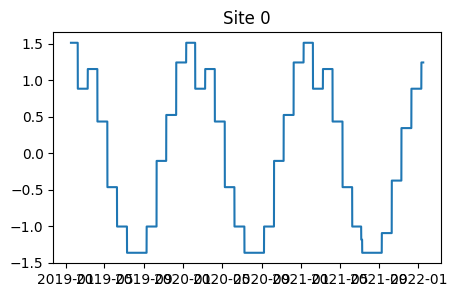

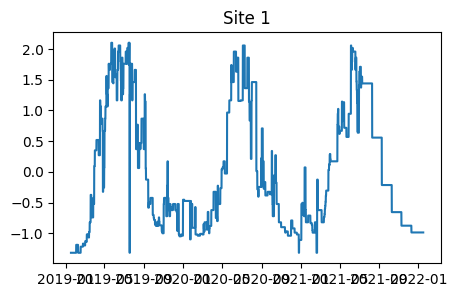

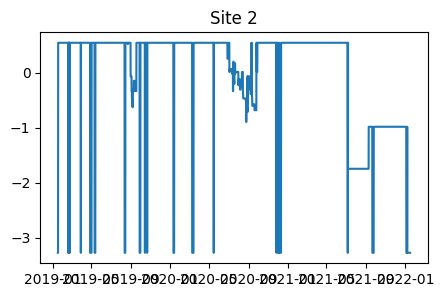

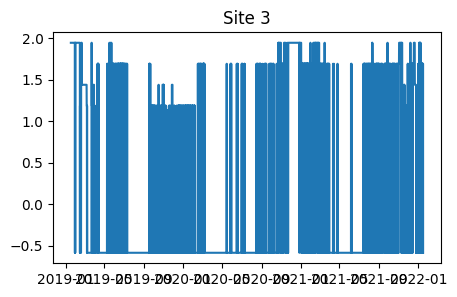

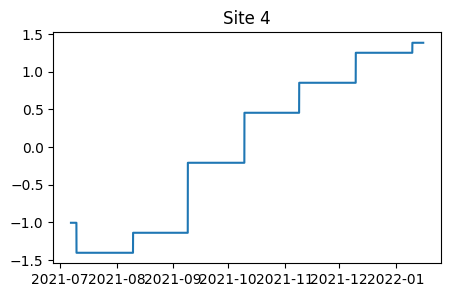

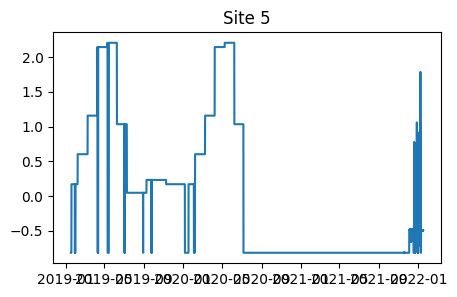

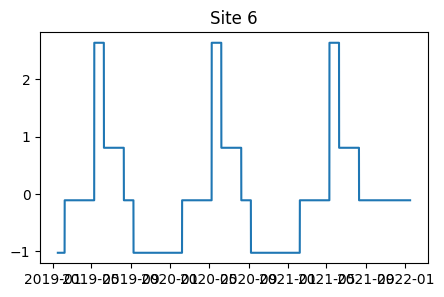

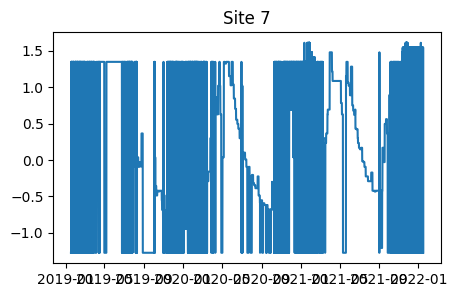

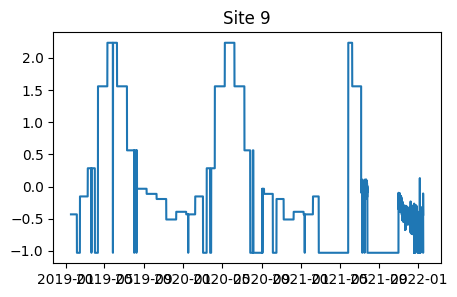

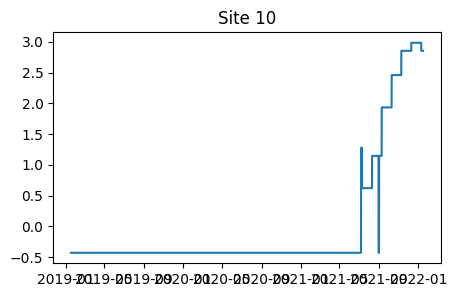

In [3]:
# pour chaque SERIE_NAME (= une série temporelle), on plot la série temporelle

# enlever les groupes de SERIE_NAME qui n'ont que des 0
df = df.groupby('SERIE_NAME').filter(lambda x: x['VALUE'].sum() != 0)

for serie_name in df['SERIE_NAME'].unique()[:10]:
    df_serie = df[df['SERIE_NAME'] == serie_name]
    plt.figure(figsize=(5, 3))
    plt.plot(df_serie['TIME'], df_serie['VALUE'])
    plt.title(serie_name)
    plt.show()

Je définis deux normalisations : une entre 0 et 1 et une en énergie.

In [4]:
def normalize_energy(series):
    # Calcul de l'énergie totale de la série
    energy = np.sum(np.square(series))
    # Normalisation par la racine carrée de l'énergie
    normalized_series = series / np.sqrt(energy)
    return normalized_series


# Normaliser chaque série temporelle par son énergie
df['VALUE_n_energy'] = df.groupby(
    'SERIE_NAME')['VALUE'].transform(normalize_energy)

# normalisation entre 0 et 1
df['VALUE_n_01'] = df.groupby('SERIE_NAME')['VALUE'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()))

Fonction pour afficher une série avec unisuqment son numéro :

In [5]:
def time_s_plot(serie_num):
    serie_name = 'Site ' + str(serie_num)
    df_serie = df[df['SERIE_NAME'] == serie_name]
    plt.figure(figsize=(20, 3))
    plt.plot(df_serie['TIME'], df_serie['VALUE'])
    plt.title(serie_name)
    plt.show()

Je sépare mes séries en un ensemble d'entrainement pour définir mes clusters et un ensemble de test pour prévoir les clusters d'appartenance (les 10 premieres séries sont assez variées).

In [6]:
# garder les 10 premières series temporelles à part pour les tests
df_test = df[df['SERIE_NAME'].isin(df['SERIE_NAME'].unique()[:10])]

# garder les autres series temporelles pour l'entrainement
df = df[~df['SERIE_NAME'].isin(df['SERIE_NAME'].unique()[:10])]

## 2. Trouver les features intéressantes

In [7]:
# Features de base
def features_base(tab):
    min = tab.groupby('SERIE_NAME')['VALUE_n_energy'].min()
    max = tab.groupby('SERIE_NAME')['VALUE_n_energy'].max()
    mean = tab.groupby('SERIE_NAME')['VALUE_n_01'].mean()
    std = tab.groupby('SERIE_NAME')['VALUE_n_01'].std()
    median = tab.groupby('SERIE_NAME')['VALUE_n_energy'].median()
    energy = tab.groupby('SERIE_NAME')['VALUE_n_01'].apply(
        lambda x: np.sum(np.square(x)))
    return min, max, mean, std, median, energy


min, max, mean, std, median, energy = features_base(df)

Premières idées de features pour caractériser les comportements recherchés (chaotique, pediodique, continu, discret, stationnaire) :

In [8]:

def features_plus(tab):
    # essayer de capturer l'aspect chaotique d'un signal :
    # somme des std sur des fenetre de 5 valeurs
    std_sum = tab.groupby('SERIE_NAME')['VALUE_n_01'].apply(
        lambda x: x.rolling(5).std().sum())

    # essayer de capturer l'aspect discret/ continu d'un signal :
    # nombre de valeurs différentes
    nunique = tab.groupby('SERIE_NAME')['VALUE'].nunique()

    # proportion d'occurence de la valeur la plus representée parmi toutes les valeurs prises
    max_occurence = tab.groupby('SERIE_NAME')['VALUE'].apply(
        lambda x: x.value_counts().max()) / tab.groupby('SERIE_NAME')['VALUE'].count()

    # essayer de capturer la periodicite d'un signal :
    # amplitude de la fréquence dominante fourier
    amplitude = tab.groupby('SERIE_NAME')['VALUE_n_energy'].apply(
        lambda x: np.abs(np.fft.rfft(x)).max())

    # amplitude de l'harmonique 1 par rapport à la fréquence d'amplitude max

    def amplitude_harmonique1(x):
        # les deux plus grandes amplitudes
        f0, f1 = np.abs(np.fft.rfft(x)).argsort()[-2:]
        return abs(f1 - 2*f0)

    fréquence_h1 = tab.groupby('SERIE_NAME')[
        'VALUE_n_energy'].apply(amplitude_harmonique1)

    # rapport d'amplitude entre les basses fréquence et les hautes fréquences
    rapport_amplitude = tab.groupby('SERIE_NAME')['VALUE_n_energy'].apply(lambda x: np.abs(
        np.fft.rfft(x)[len(x)//2:]).sum()/np.abs(np.fft.rfft(x)[:len(x)//2]).sum())

    # stationnarité
    # coefficient de variation de la variance sur des fenetres du signal

    def coef_var(x):
        return x.rolling(5).std().rolling(5).std().mean()

    coef_var = tab.groupby('SERIE_NAME')[
        'VALUE_n_01'].apply(lambda x: coef_var(x))

    return std_sum, nunique, max_occurence, amplitude, fréquence_h1, coef_var, rapport_amplitude


std_sum, nunique, max_occurence, amplitude, fréquence_h1, coef_var, rapport_amplitude = features_plus(
    df)

Je fais un tableau des features pour mes séries d'entrainement :

In [9]:
features = pd.DataFrame({'min': min, 'max': max, 'median': median, 'mean': mean, 'std': std, 'std_sum': std_sum, 'nunique': nunique,
                        'max_occurence': max_occurence, 'ampl_fondamental': amplitude, 'fréquence_h1': fréquence_h1,  'coef_var': coef_var, 'rapport_amplitude': rapport_amplitude})
features.head()

min       max    median      mean       std      std_sum  \
SERIE_NAME                                                                  
Site 100   -0.007830  0.008495 -0.001290  0.479641  0.267200   288.453695   
Site 101   -0.002415  0.008849 -0.002415  0.214420  0.387235  2077.159915   
Site 102   -0.010483  0.030218 -0.000308  0.257567  0.120998     2.487340   
Site 103   -0.019764  0.001429  0.001429  0.932588  0.205824    66.063760   
Site 104   -0.005418  0.012580 -0.001265  0.301029  0.242353  1571.844887   

            nunique  max_occurence  ampl_fondamental  fréquence_h1  coef_var  \
SERIE_NAME                                                                     
Site 100       4641       0.107763        104.847877             9  0.003192   
Site 101          4       0.764288         74.442608             1  0.031033   
Site 102          3       0.941793         38.297008             7  0.000060   
Site 103          3       0.830061         43.392127            31  0.001245   
Site 104        290       0.101084         68.399144             9  0.020293   

            rapport_amplitude  
SERIE_NAME                     
Site 100         4.466724e-05  
Site 101         3.082044e-06  
Site 102         2.006695e-19  
Site 103         1.144676e-20  
Site 104         2.467321e-05

Je clusterise en 5 catégories avec un Kmédoid (plus robuste que le Kmean aux valeurs aberrantes car il fonctionne avec des médianes) :

In [10]:
# clustering des series temporelles avec les features en 5 catégories avec Kmédoids (representants médians des clusters et plus de robustesse aux outliers)
from sklearn_extra.cluster import KMedoids
kmedoids = KMedoids(n_clusters=5, random_state=0).fit(features)
features['cluster_n5'] = kmedoids.labels_
features.head()

min       max    median      mean       std      std_sum  \
SERIE_NAME                                                                  
Site 100   -0.007830  0.008495 -0.001290  0.479641  0.267200   288.453695   
Site 101   -0.002415  0.008849 -0.002415  0.214420  0.387235  2077.159915   
Site 102   -0.010483  0.030218 -0.000308  0.257567  0.120998     2.487340   
Site 103   -0.019764  0.001429  0.001429  0.932588  0.205824    66.063760   
Site 104   -0.005418  0.012580 -0.001265  0.301029  0.242353  1571.844887   

            nunique  max_occurence  ampl_fondamental  fréquence_h1  coef_var  \
SERIE_NAME                                                                     
Site 100       4641       0.107763        104.847877             9  0.003192   
Site 101          4       0.764288         74.442608             1  0.031033   
Site 102          3       0.941793         38.297008             7  0.000060   
Site 103          3       0.830061         43.392127            31  0.001245   
Site 104        290       0.101084         68.399144             9  0.020293   

            rapport_amplitude  cluster_n5  
SERIE_NAME                                 
Site 100         4.466724e-05           4  
Site 101         3.082044e-06           2  
Site 102         2.006695e-19           1  
Site 103         1.144676e-20           1  
Site 104         2.467321e-05           2

In [11]:
# afficher les representants médians des clusters
representants = features.groupby('cluster_n5').median()
representants

min       max    median      mean       std      std_sum  \
cluster_n5                                                                  
0          -0.006434  0.006453 -0.000181  0.492580  0.312665    13.652735   
1          -0.005831  0.011044 -0.000784  0.275054  0.263751     7.959489   
2          -0.003453  0.009054 -0.002192  0.265943  0.336155  1571.844887   
3          -0.006216  0.008123 -0.000554  0.420145  0.302920   102.904216   
4          -0.006627  0.008266 -0.000964  0.435363  0.284424   316.671165   

            nunique  max_occurence  ampl_fondamental  fréquence_h1  coef_var  \
cluster_n5                                                                     
0               8.5       0.287215        139.416796           9.0  0.000258   
1               8.0       0.592762         77.435830           3.0  0.000185   
2             136.0       0.418531         65.487843           5.0  0.025976   
3              79.0       0.242009        100.179483           1.0  0.001814   
4            2471.0       0.166781         99.450732           7.0  0.003483   

            rapport_amplitude  
cluster_n5                     
0                    0.000000  
1                    0.000000  
2                    0.000033  
3                    0.000003  
4                    0.000009

Regardons les clusters. à l'aide de 10 exemples de chaque : 

Cluster 4


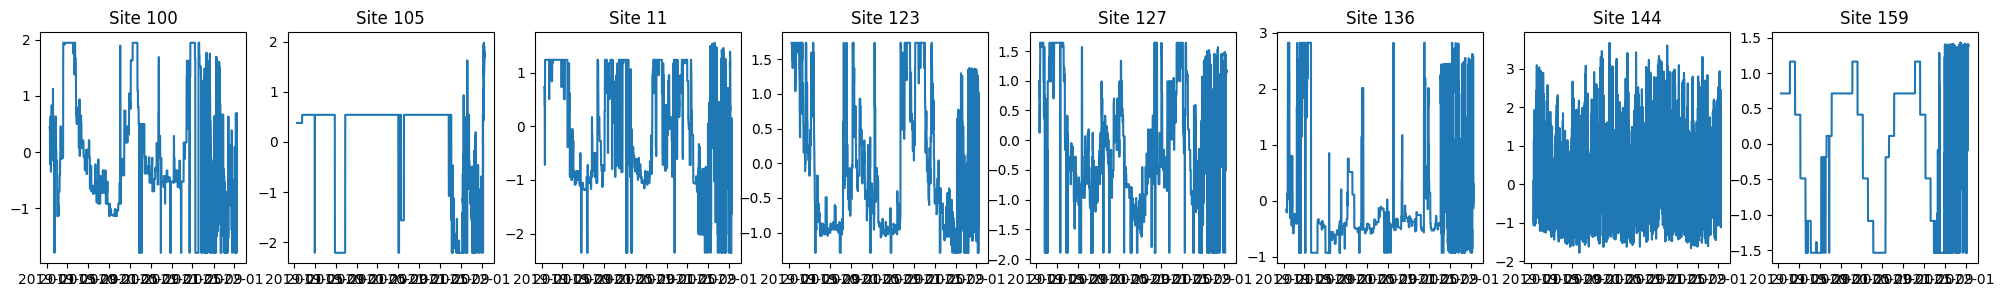

Cluster 2


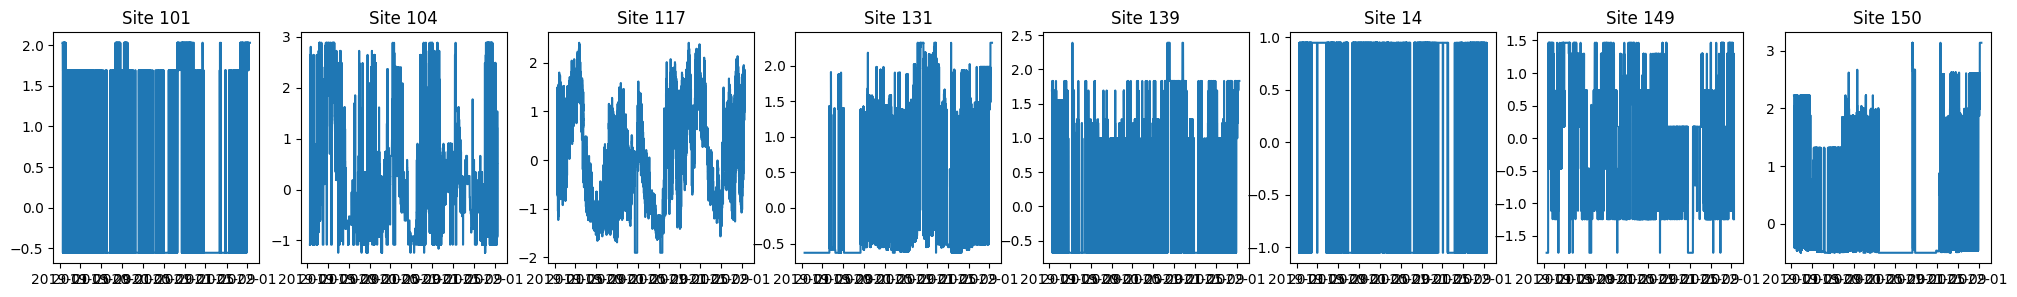

Cluster 1


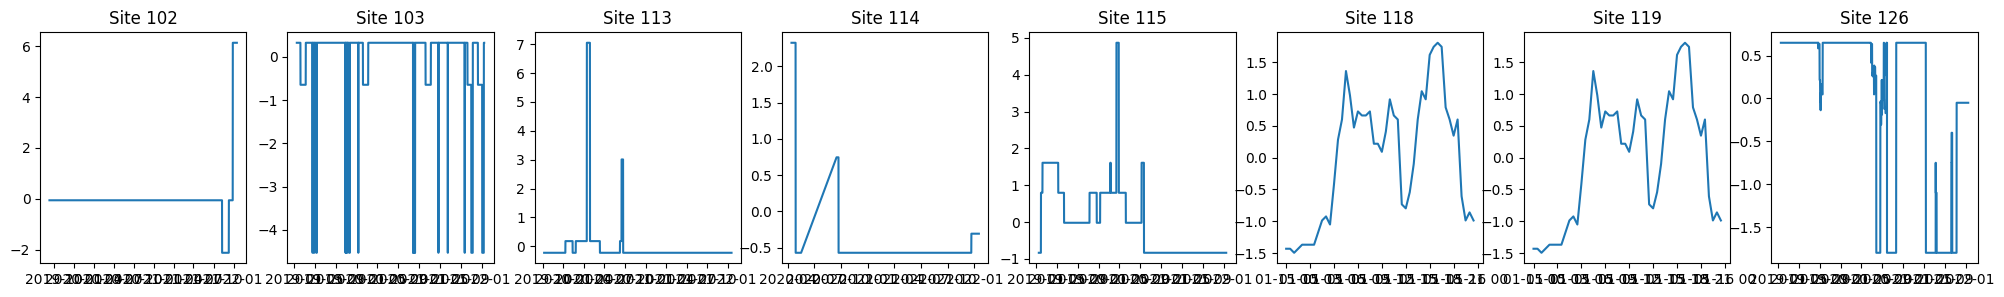

Cluster 3


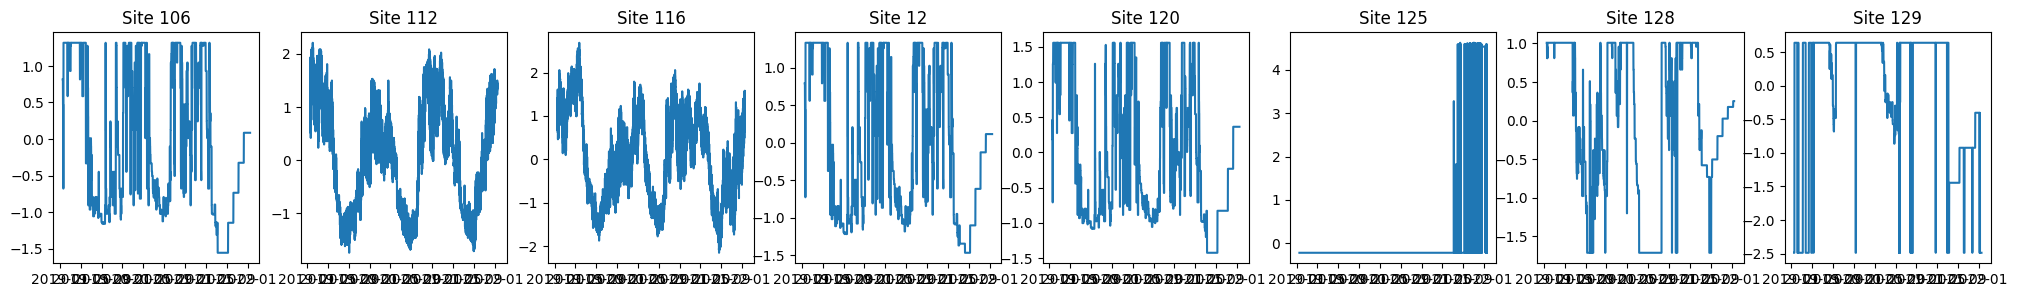

Cluster 0


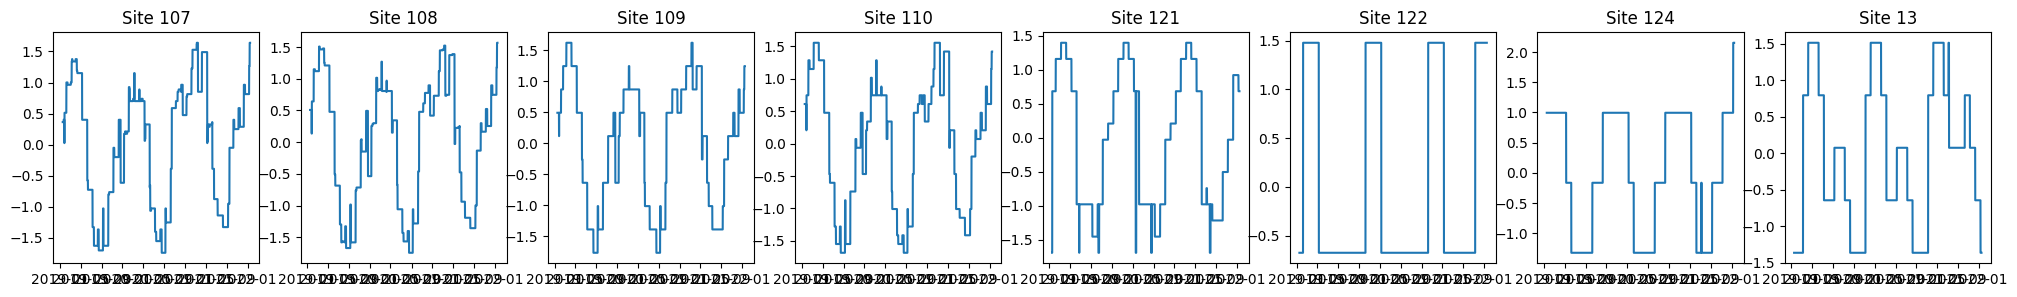

In [12]:
for cluster in features['cluster_n5'].unique():
    print(f'Cluster {cluster}')
    plt.figure(figsize=(25, 3))
    for i, serie_name in enumerate(features[features['cluster_n5'] == cluster].index[:8]):
        df_serie = df[df['SERIE_NAME'] == serie_name]
        plt.subplot(1, 8, i+1)
        plt.plot(df_serie['TIME'], df_serie['VALUE'])
        plt.title(serie_name)
    plt.show()

Rapport d'importances des features entre les représentants de chaque cluster (obtenu par la médiane) :

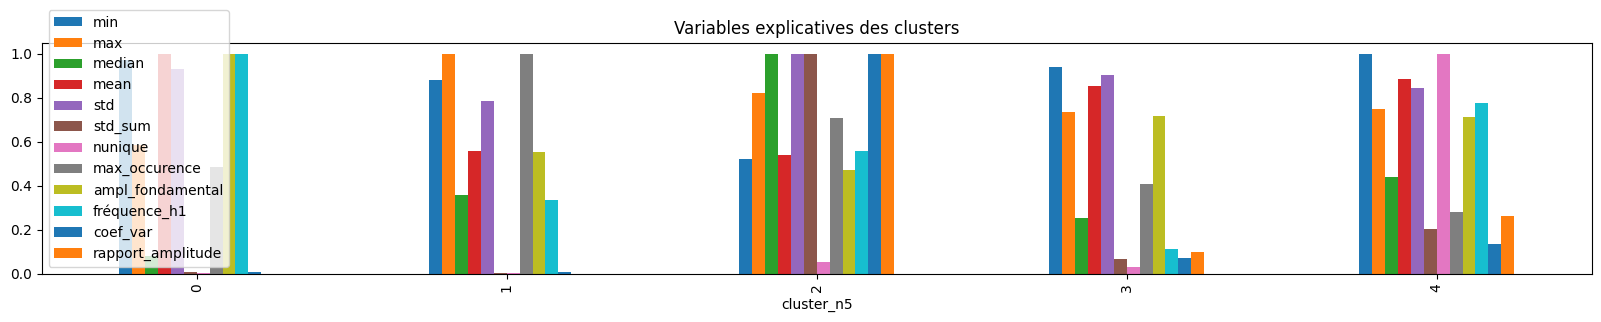

In [13]:
# variables explicatives des clusters, legend en bas
(abs(representants)/abs(representants).max()).plot.bar(figsize=(20, 3),
                                                       legend=True, title='Variables explicatives des clusters')
plt.show()

On remarque que :

- amplitude différencie bien les signaux périodique (cluster 0)
- std_sum différencie bien les signaux chaotique (cluster 3) ainsi que nunique.
- max_occurence discrimine des signaux assez "plats" du cluster 1.
- nunique rend bien compte des signaux chaotique (cluster 2,4) et surtout continu (cluster 4) ou il est important, et des clusters plus discrets comme le cluster 0 lorsqu'il est plus faible/
- rapport_amplitude fait bien la distinction entre les signaux plus 'bruités' (clusters 2)/voire chaotique et ceux plus lisses (cluster0)
- coef_var distingue bien les signaux chaotiques (cluster 2) de ceux qui ne le sont pas.



- min et max ne semblent pas pertinent
- fréquence_h1 ne semble pas pertinent

- On retrouve bien un cluster 2 assez chaotique (std importante) et continu et non stationnaire , avec std_sum maximum, rapport amplitude haute sur amplitude basse élevé, et un coefficient de variation très important.
- On retrouve un cluster 3 assez périodique (amplitude fondamental important), avec beaucoup moins de variation et de fréquence haute que le cluster 2, plus continu et un peu bruité.
- On retrouve un cluster 0 discret (nunique faible), périodique (amplitude fondamental fort et peu de fréquence haute ) et donc stationnaire.
- On retrouve un cluster 1 assez chaotique et non stationnaire et discret (max_occurence maximum, peu de nunique).
- On retrouve un cluster 4 assez chaotique (std_sum non nul et un rapport _amplitude non plus et des amplitudeen fréquence haute non négligeable), continu (nunique fort).

Mais parmi toutes les possibilits , a-t-on bien délimité tout les cas afin que le nombre de cluster soit pertinent ? ( à nombre de charactéristique égal, ici 5)

----

ESSAI 2 : on enlève ce qui semble moins pertinent, on combine les features.

Plus que la moyenne et la médiane, la différence des deux peut nous donner une mesure de dispersion/ variation des valeurs sans que cela reste trop isolé.
On ne garde que certaines features : 

In [14]:
features_2 = pd.DataFrame({'median': median - mean, 'std_sum': std_sum, 'nunique': nunique,
                          'ampl_fondamental': amplitude,  'coef_var': coef_var, 'rapport_amplitude': rapport_amplitude})
features_2.head()

median      std_sum  nunique  ampl_fondamental  coef_var  \
SERIE_NAME                                                               
Site 100   -0.480932   288.453695     4641        104.847877  0.003192   
Site 101   -0.216835  2077.159915        4         74.442608  0.031033   
Site 102   -0.257875     2.487340        3         38.297008  0.000060   
Site 103   -0.931159    66.063760        3         43.392127  0.001245   
Site 104   -0.302293  1571.844887      290         68.399144  0.020293   

            rapport_amplitude  
SERIE_NAME                     
Site 100         4.466724e-05  
Site 101         3.082044e-06  
Site 102         2.006695e-19  
Site 103         1.144676e-20  
Site 104         2.467321e-05

In [15]:
kmedoids_2 = KMedoids(n_clusters=5, random_state=0).fit(features_2)
features_2['cluster'] = kmedoids_2.labels_
features_2.head()

median      std_sum  nunique  ampl_fondamental  coef_var  \
SERIE_NAME                                                               
Site 100   -0.480932   288.453695     4641        104.847877  0.003192   
Site 101   -0.216835  2077.159915        4         74.442608  0.031033   
Site 102   -0.257875     2.487340        3         38.297008  0.000060   
Site 103   -0.931159    66.063760        3         43.392127  0.001245   
Site 104   -0.302293  1571.844887      290         68.399144  0.020293   

            rapport_amplitude  cluster  
SERIE_NAME                              
Site 100         4.466724e-05        0  
Site 101         3.082044e-06        4  
Site 102         2.006695e-19        1  
Site 103         1.144676e-20        1  
Site 104         2.467321e-05        4

In [16]:
# afficher les representants médians des clusters
representants_2 = features_2.groupby('cluster').median()
representants_2

median      std_sum  nunique  ampl_fondamental  coef_var  \
cluster                                                               
0       -0.436655   316.671165   2471.0         99.450732  0.003483   
1       -0.350461     7.959489      7.0         79.770635  0.000185   
2       -0.491963    13.652735      8.5        141.077824  0.000258   
3       -0.413815   102.795110     78.0         99.905359  0.001806   
4       -0.268963  1571.844887    136.0         65.487843  0.025976   

         rapport_amplitude  
cluster                     
0                 0.000009  
1                 0.000000  
2                 0.000000  
3                 0.000003  
4                 0.000033

Cluster 0


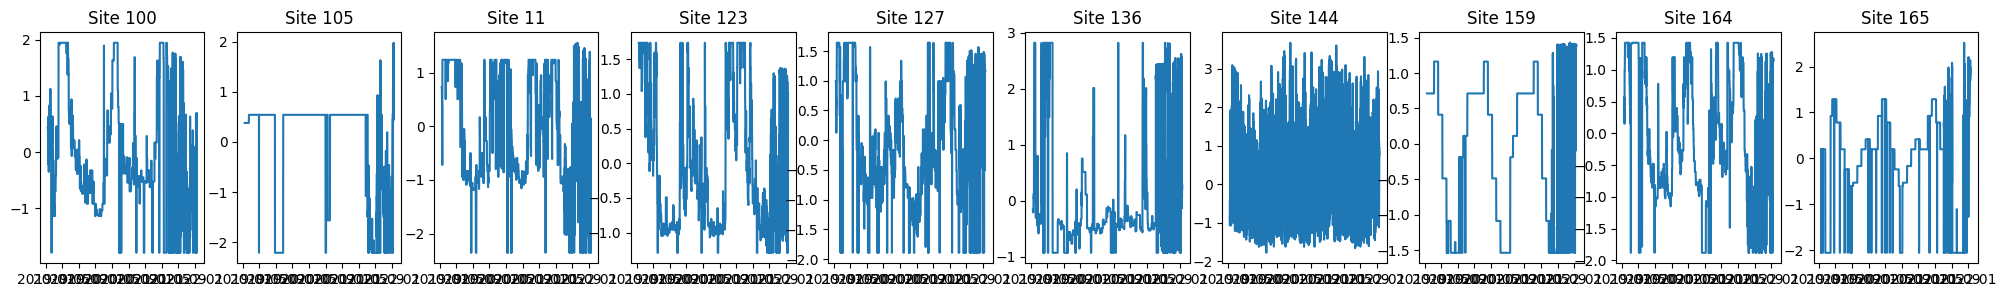

Cluster 4


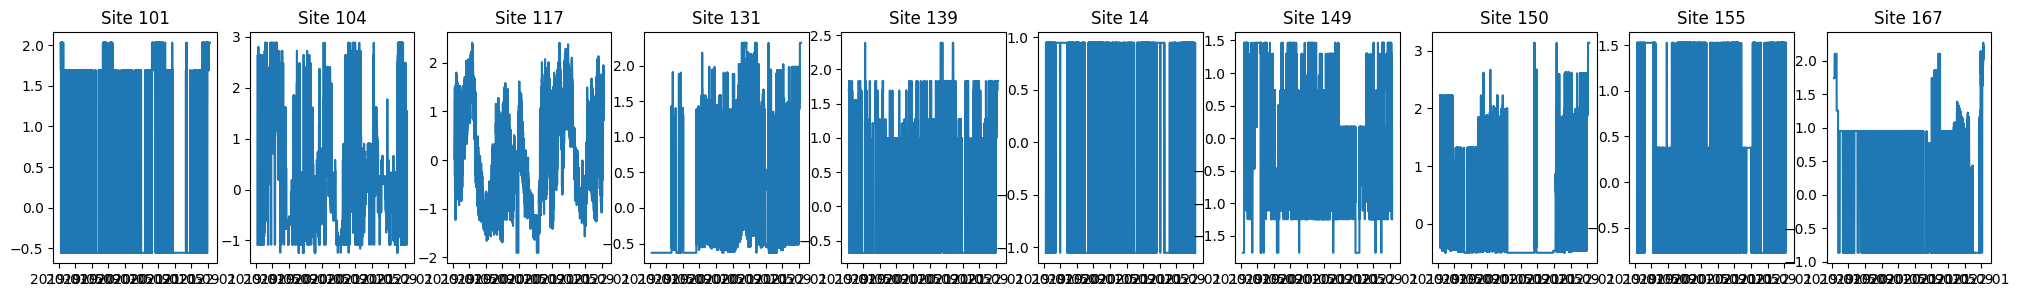

Cluster 1


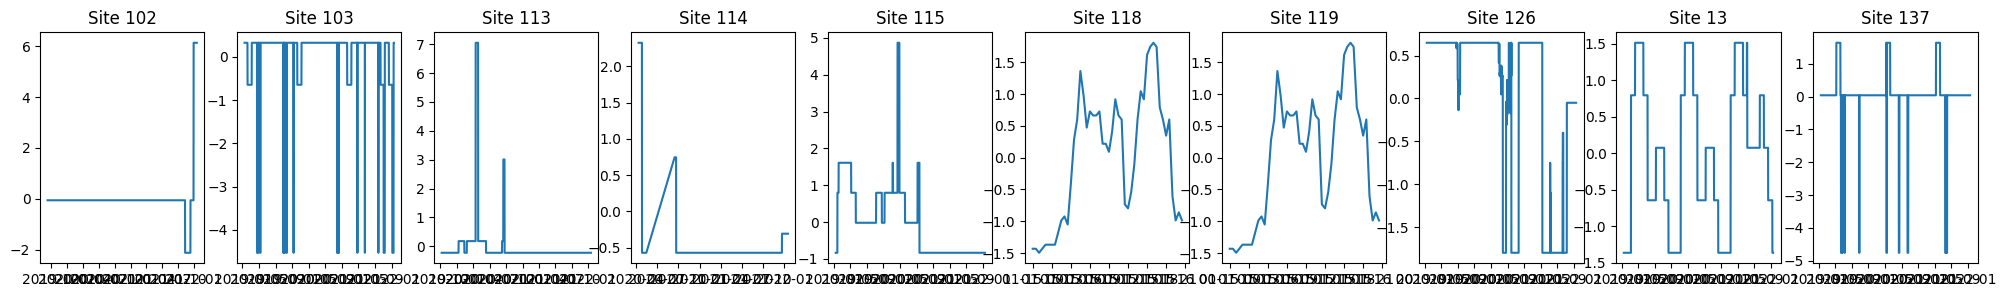

Cluster 3


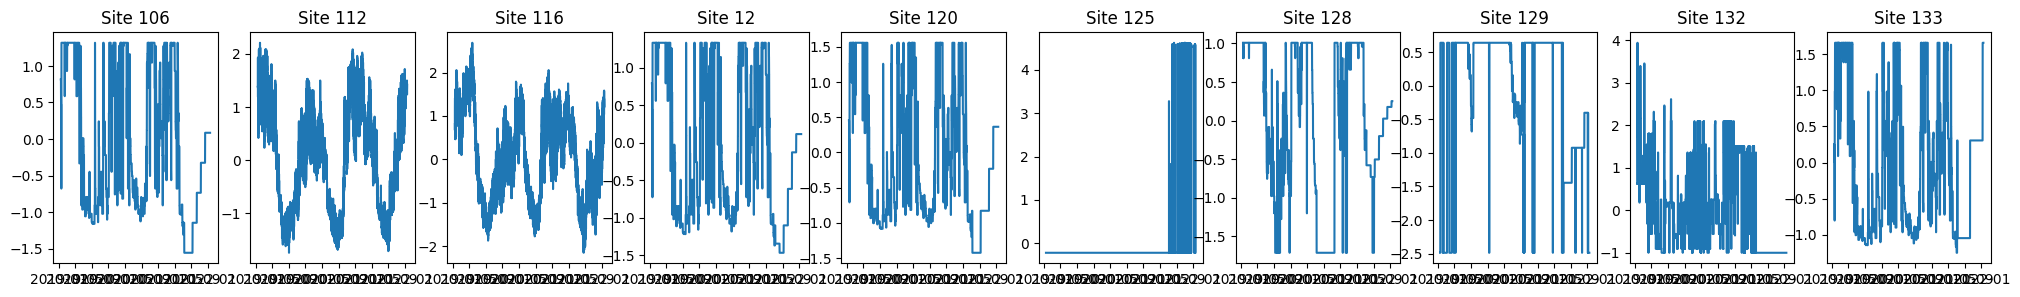

Cluster 2


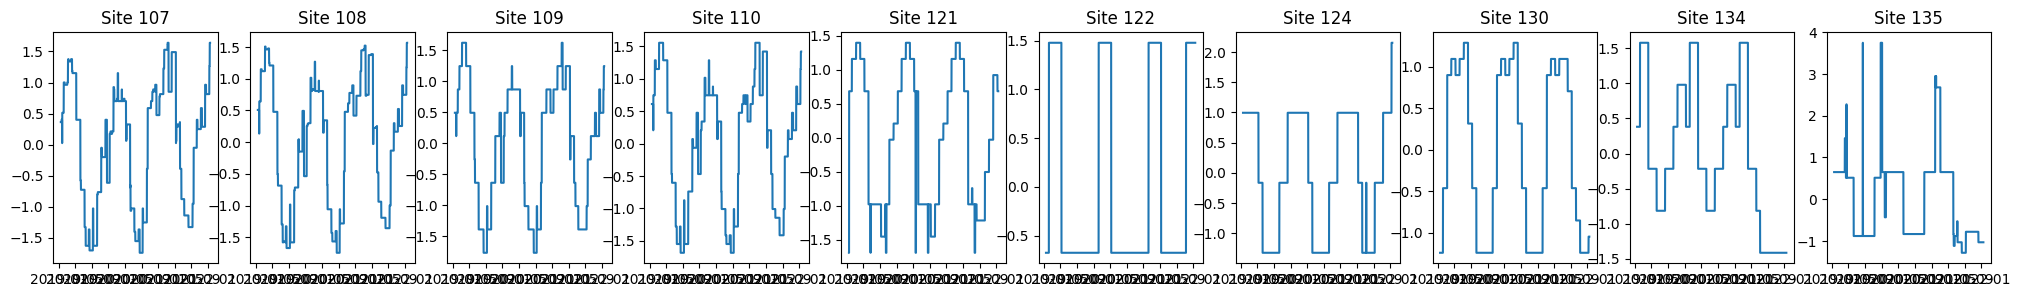

In [17]:
for cluster in features_2['cluster'].unique():
    print(f'Cluster {cluster}')
    plt.figure(figsize=(25, 3))
    for i, serie_name in enumerate(features_2[features_2['cluster'] == cluster].index[:10]):
        df_serie = df[df['SERIE_NAME'] == serie_name]
        plt.subplot(1, 10, i+1)
        plt.plot(df_serie['TIME'], df_serie['VALUE'])
        plt.title(serie_name)
    plt.show()

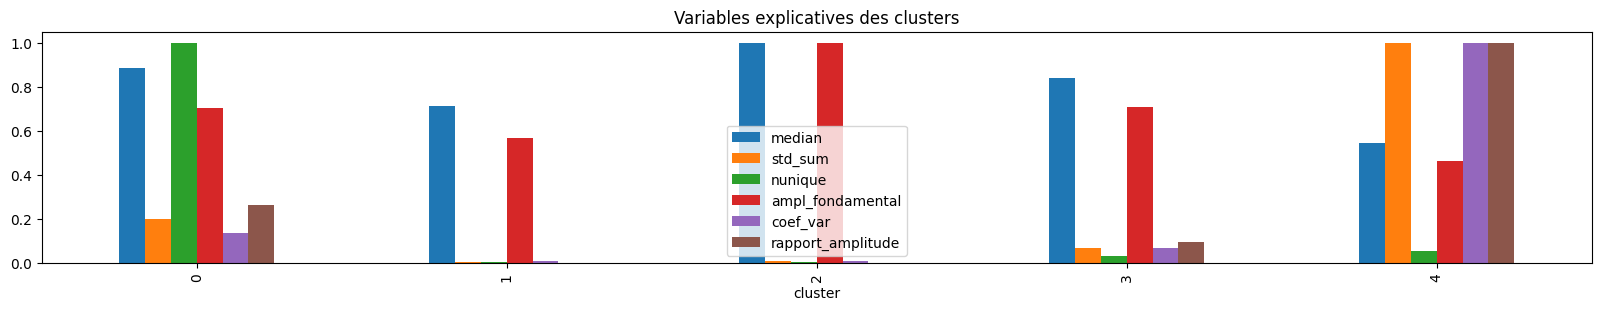

In [18]:
# variables explicatives des clusters, legend en bas
(abs(representants_2)/abs(representants_2).max()).plot.bar(figsize=(20, 3),
                                                           legend=True, title='Variables explicatives des clusters')
plt.show()

On voit que ca a moins bien marché (ex : site 13 périodique discret est dans le cluster 1 qui ne l'est pas alors que le cluster 2 l'est ).

# 3. Prediction

In [19]:
# predire dans quel cluster se retrouvera chaque serie de df_test
min_test, max_test, mean_test, std_test, median_test, energy_test = features_base(
    df_test)
std_sum_test, nunique_test, max_occurence_test, amplitude_test, fréquence_h1_test, coef_var_test, rapport_amplitude_test = features_plus(
    df_test)

features_test = pd.DataFrame({'min': min_test, 'max': max_test, 'median': median_test, 'mean': mean_test, 'std': std_test, 'std_sum': std_sum_test, 'nunique': nunique_test,
                             'max_occurence': max_occurence_test, 'ampl_fondamental': amplitude_test, 'fréquence_h1': fréquence_h1_test,  'coef_var': coef_var_test, 'rapport_amplitude': rapport_amplitude_test})
features_test['cluster_n5'] = kmedoids.predict(features_test)
features_test.head()

min       max    median      mean       std      std_sum  \
SERIE_NAME                                                                  
Site 0     -0.005943  0.006590 -0.000460  0.474201  0.348050    12.871986   
Site 1     -0.005740  0.009165 -0.001586  0.385093  0.292638    48.059910   
Site 10    -0.001870  0.013019 -0.001870  0.125588  0.292975     4.668547   
Site 2     -0.014291  0.002382  0.002382  0.857139  0.261611    93.026530   
Site 3     -0.002541  0.008484 -0.002541  0.230451  0.395663  1993.627586   

            nunique  max_occurence  ampl_fondamental  fréquence_h1  coef_var  \
SERIE_NAME                                                                     
Site 0           14       0.167123        157.757116            63  0.000243   
Site 1          156       0.037443        142.812533             9  0.000908   
Site 10           8       0.825304         94.173200             3  0.000088   
Site 2           32       0.694901         60.425297             3  0.001757   
Site 3           12       0.742846         70.189482             1  0.031143   

            rapport_amplitude  cluster_n5  
SERIE_NAME                                 
Site 0               0.000000           0  
Site 1               0.000000           3  
Site 10              0.000000           1  
Site 2               0.000000           3  
Site 3               0.000023           2

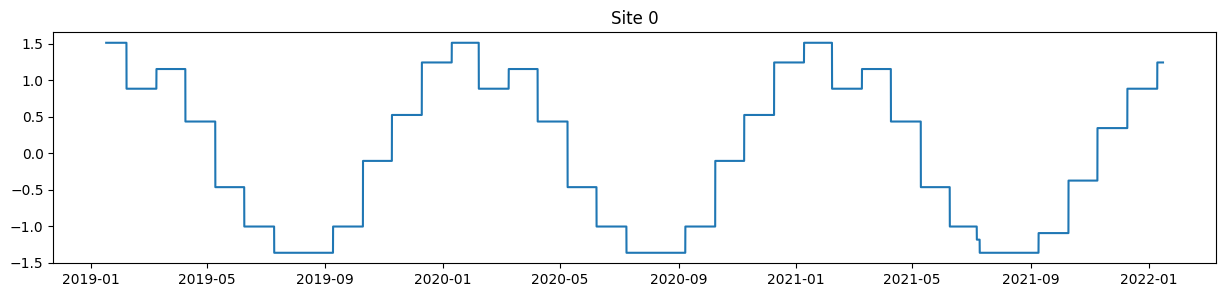

Cluster prédit : 0
Séries temporelles du cluster :


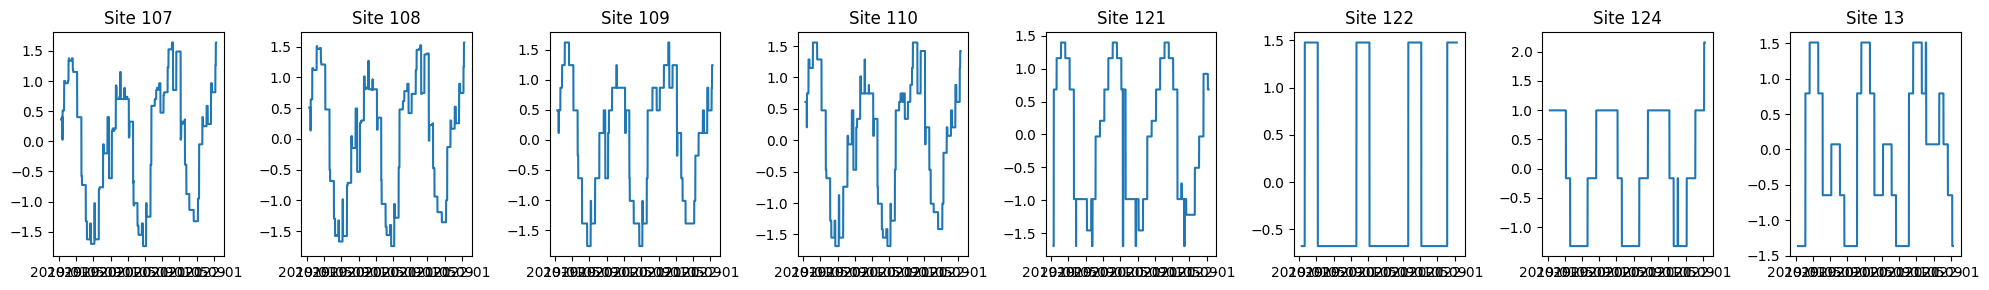

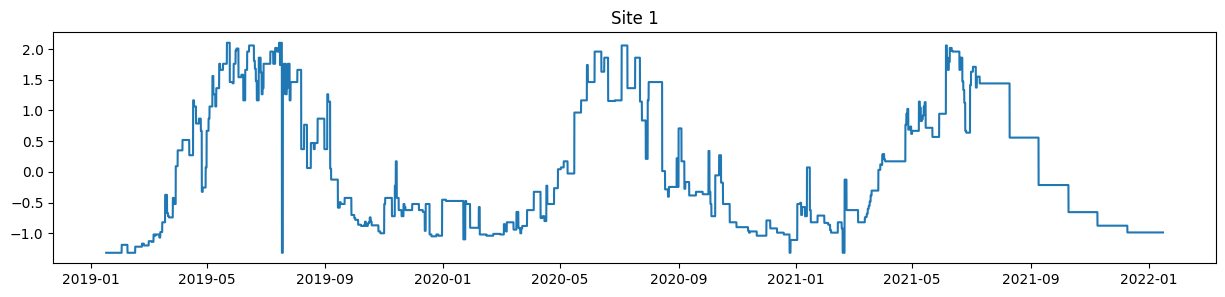

Cluster prédit : 3
Séries temporelles du cluster :


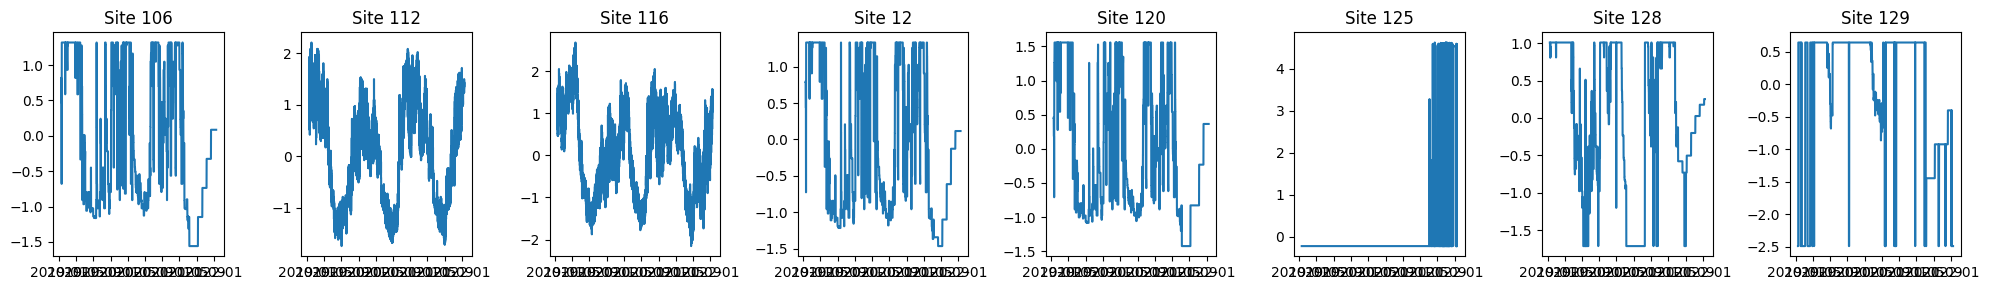

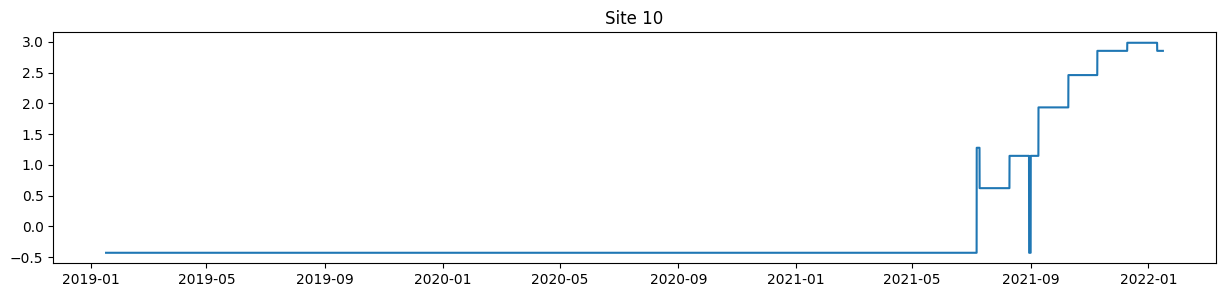

Cluster prédit : 1
Séries temporelles du cluster :


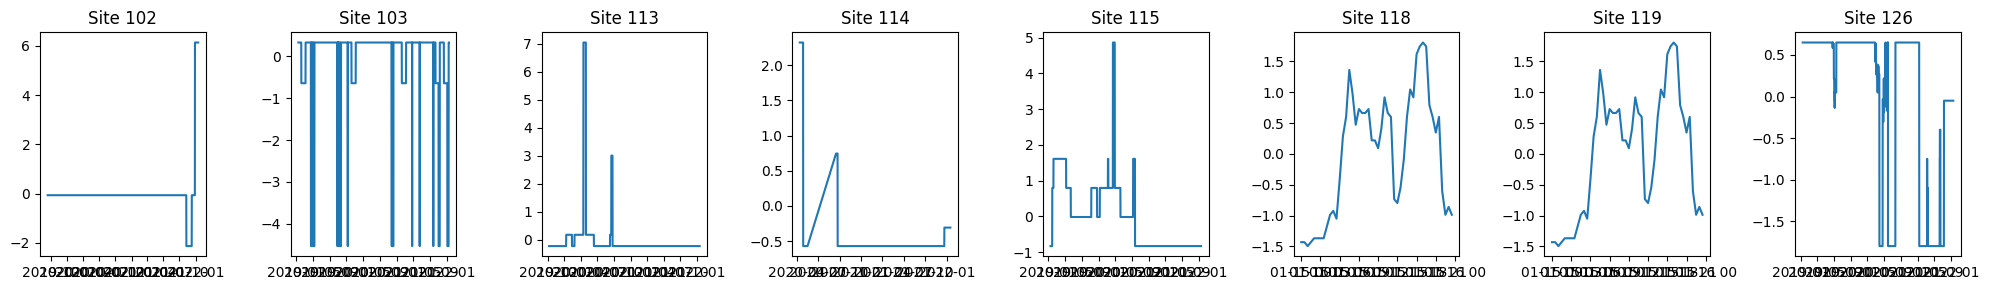

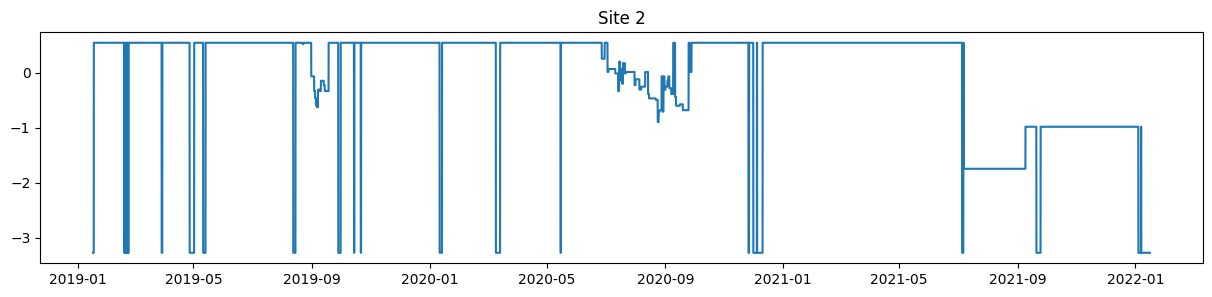

Cluster prédit : 3
Séries temporelles du cluster :


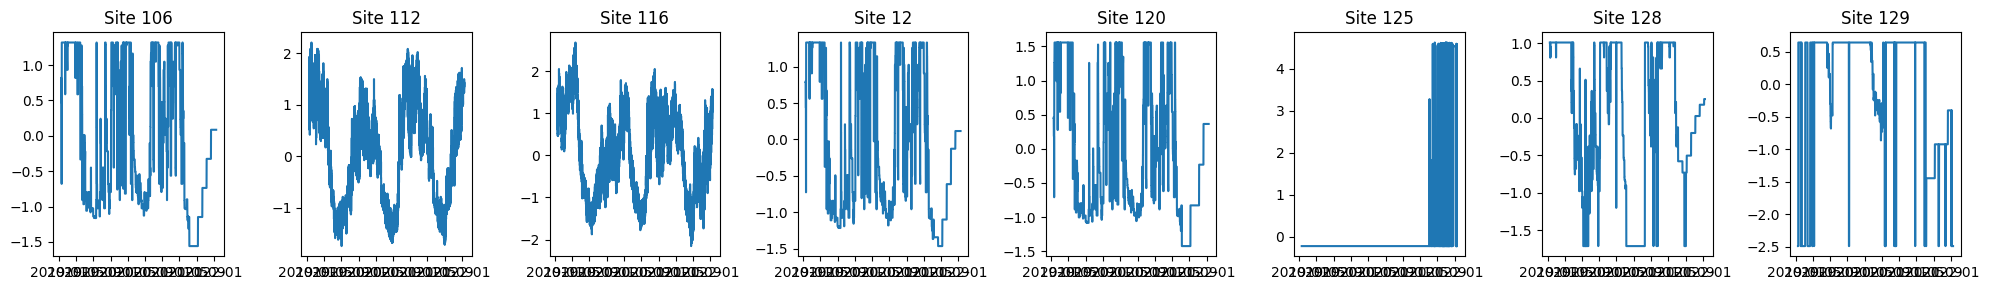

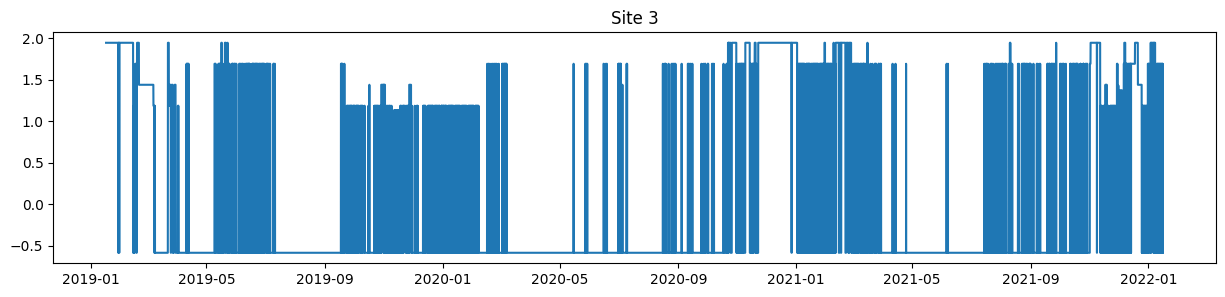

Cluster prédit : 2
Séries temporelles du cluster :


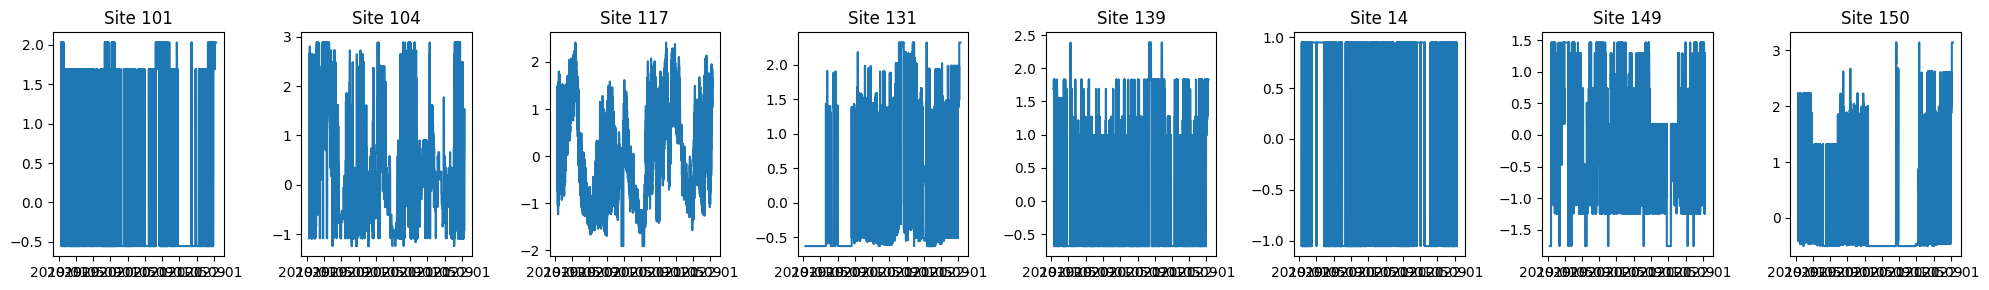

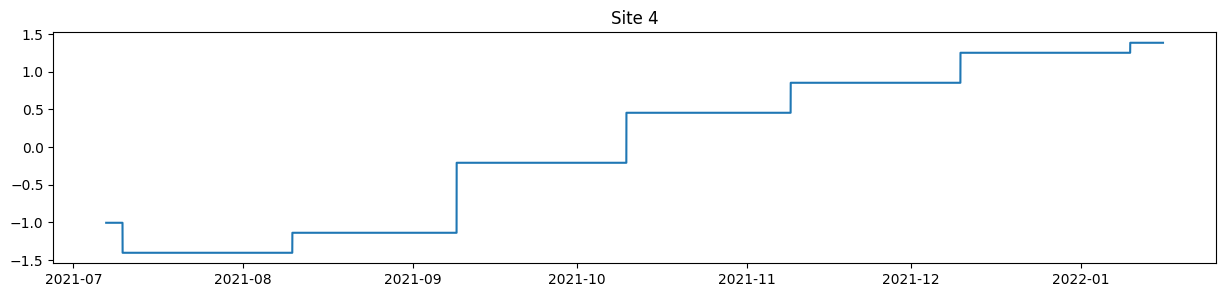

Cluster prédit : 1
Séries temporelles du cluster :


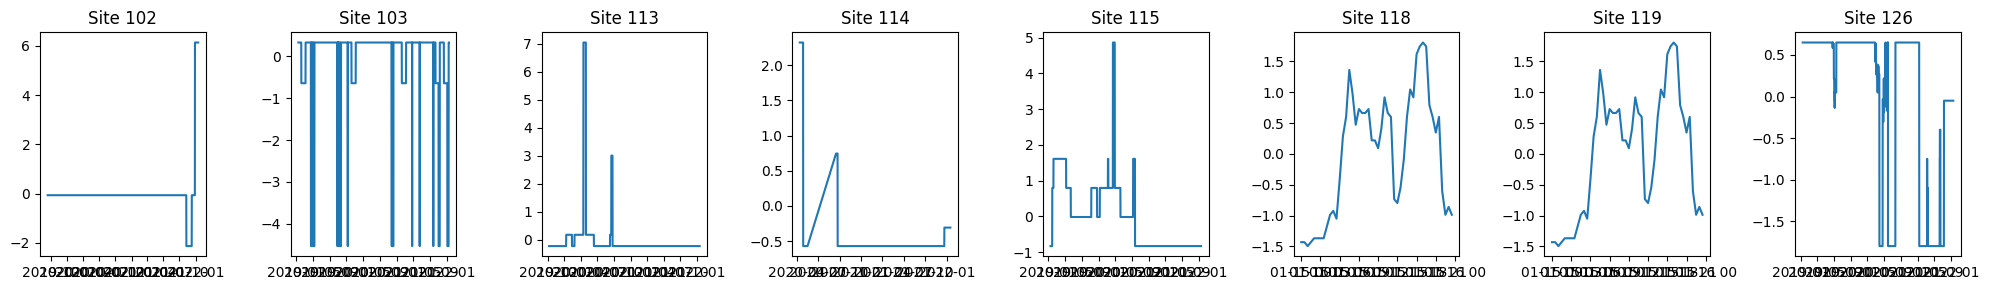

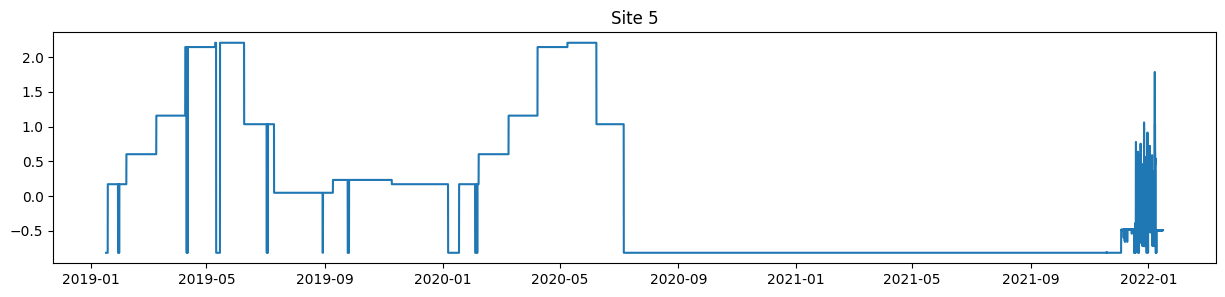

Cluster prédit : 3
Séries temporelles du cluster :


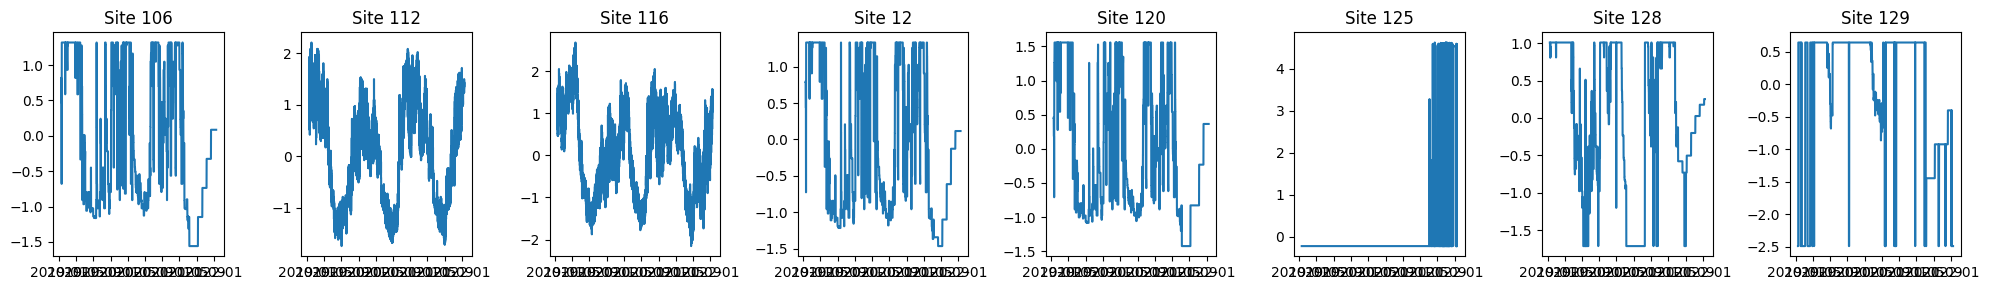

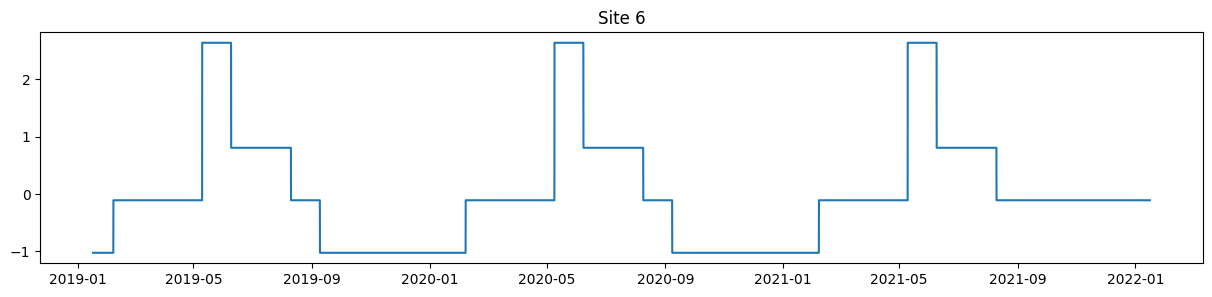

Cluster prédit : 0
Séries temporelles du cluster :


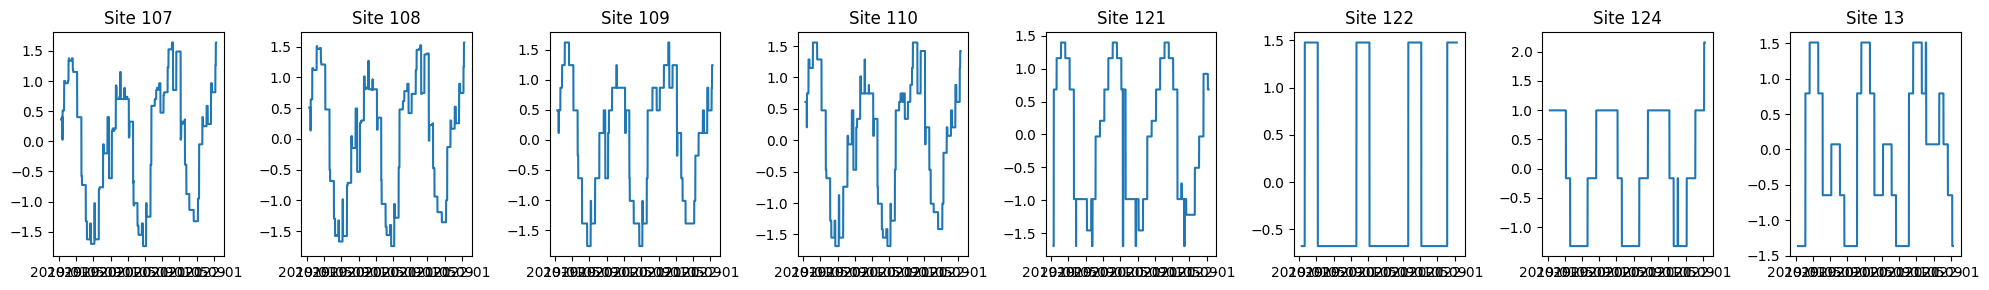

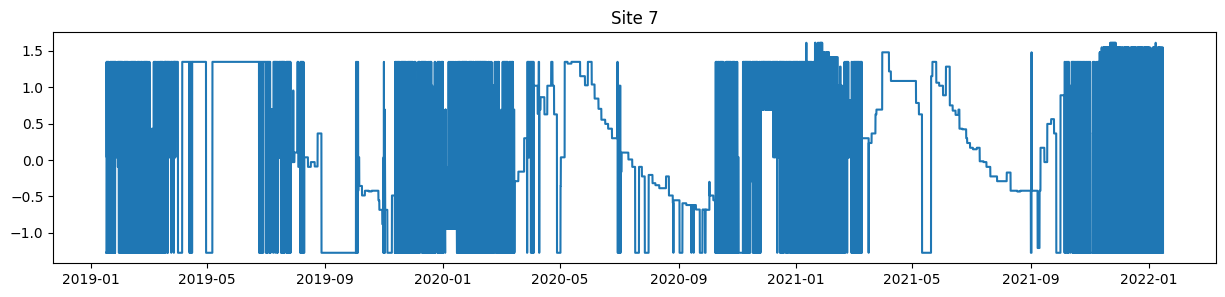

Cluster prédit : 2
Séries temporelles du cluster :


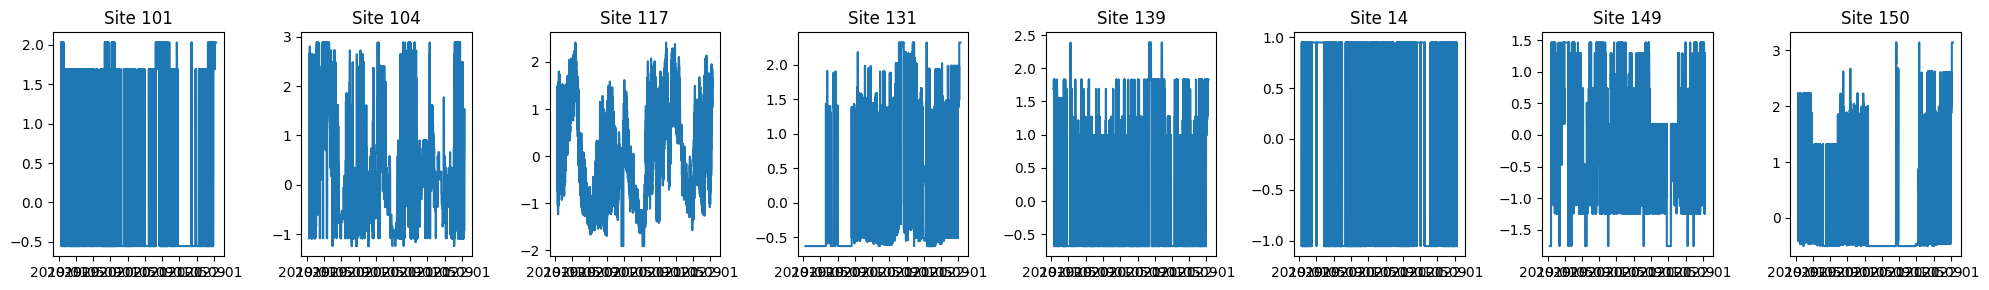

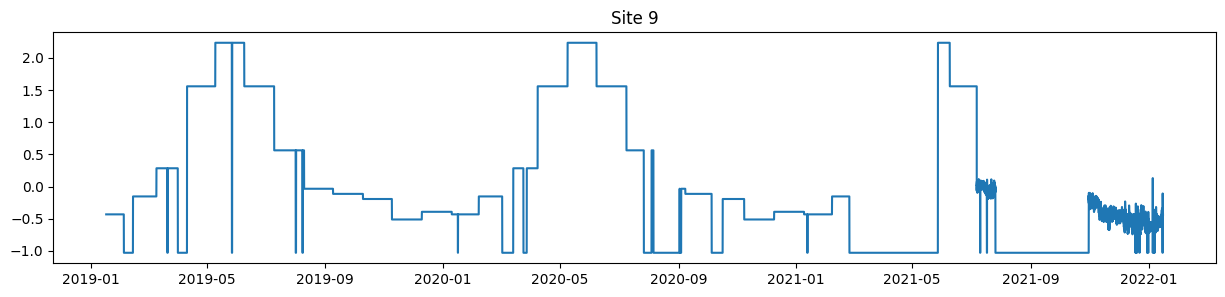

Cluster prédit : 3
Séries temporelles du cluster :


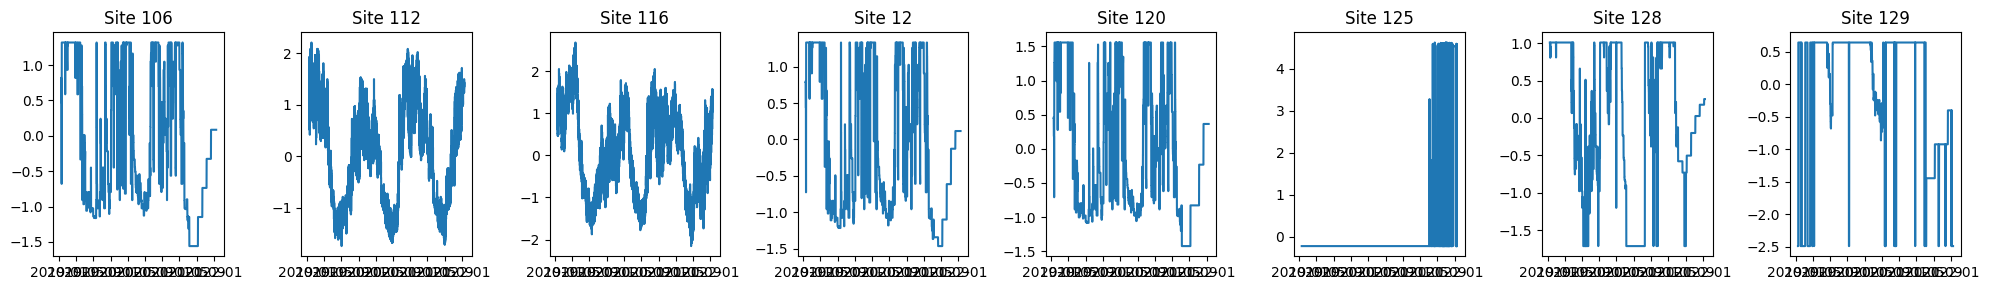

In [20]:
# Plot les séries temporelles de df_test avec les 5 premières séries de leur cluster prédit
for i, serie_name in enumerate(features_test.index[:10]):
    df_serie = df_test[df_test['SERIE_NAME'] == serie_name]
    # Ajustez la taille de la figure selon vos préférences
    plt.figure(figsize=(15, 3))
    plt.plot(df_serie['TIME'], df_serie['VALUE'])
    plt.title(serie_name)
    plt.show()

    print('Cluster prédit :', features_test.loc[serie_name, 'cluster_n5'])
    print('Séries temporelles du cluster :')

    cluster = features_test.loc[serie_name, 'cluster_n5']
    # Créez une ligne de 8 sous-graphiques
    fig, axes = plt.subplots(1, 8, figsize=(20, 3))
    for i, serie_name in enumerate(features[features['cluster_n5'] == cluster].index[:8]):
        df_serie = df[df['SERIE_NAME'] == serie_name]
        ax = axes[i]
        ax.plot(df_serie['TIME'], df_serie['VALUE'])
        ax.set_title(serie_name)

    plt.tight_layout()
    plt.show()

Visuellement il y a de bonne chose (comme le site 10 avec le cluster 1, le site 1 avec le 3, le site 0 avec le cluster 0 , le site 7 avec le 2, le site 3 avec le 2, le site 6 avec le 0, le site 4 avec le 1) et de moins bonne , comme le site 2 (discret) avec le cluster 3 (plus continu), le site 5 et 9 avec le cluster 3 aussi. 

Avant d'étudier plus en détail les charactéristiques des clusters, voyons si un autre nombre de classe ferait mieux.

-----

# Prediction à 6 classes...

On se concentre sur les 5 caractéristiques : chaotique, périodique, stationnaire, discret, continu.
Or périodique implique la sattionnarité , donc il existe que 6 combinaions. Initialement, je voulais faire une suite de clusterisation en choisissant des features qui sont spécifiques à chaque caractéristiques, mais ils sont bien souvent liés entre eux. De facon plus simple, nous pouvons donc essayer de faire un Kmédoid à 6 classes.

In [21]:
# clustering des series temporelles avec les features en 5 catégories avec Kmédoids (representants médians des clusters et plus de robustesse aux outliers)
from sklearn_extra.cluster import KMedoids
kmedoids_3 = KMedoids(n_clusters=6, random_state=0).fit(
    features.drop(columns=['cluster_n5']))
features['cluster_n6'] = kmedoids_3.labels_
features.head()

min       max    median      mean       std      std_sum  \
SERIE_NAME                                                                  
Site 100   -0.007830  0.008495 -0.001290  0.479641  0.267200   288.453695   
Site 101   -0.002415  0.008849 -0.002415  0.214420  0.387235  2077.159915   
Site 102   -0.010483  0.030218 -0.000308  0.257567  0.120998     2.487340   
Site 103   -0.019764  0.001429  0.001429  0.932588  0.205824    66.063760   
Site 104   -0.005418  0.012580 -0.001265  0.301029  0.242353  1571.844887   

            nunique  max_occurence  ampl_fondamental  fréquence_h1  coef_var  \
SERIE_NAME                                                                     
Site 100       4641       0.107763        104.847877             9  0.003192   
Site 101          4       0.764288         74.442608             1  0.031033   
Site 102          3       0.941793         38.297008             7  0.000060   
Site 103          3       0.830061         43.392127            31  0.001245   
Site 104        290       0.101084         68.399144             9  0.020293   

            rapport_amplitude  cluster_n5  cluster_n6  
SERIE_NAME                                             
Site 100         4.466724e-05           4           4  
Site 101         3.082044e-06           2           5  
Site 102         2.006695e-19           1           1  
Site 103         1.144676e-20           1           1  
Site 104         2.467321e-05           2           5

Cluster 4


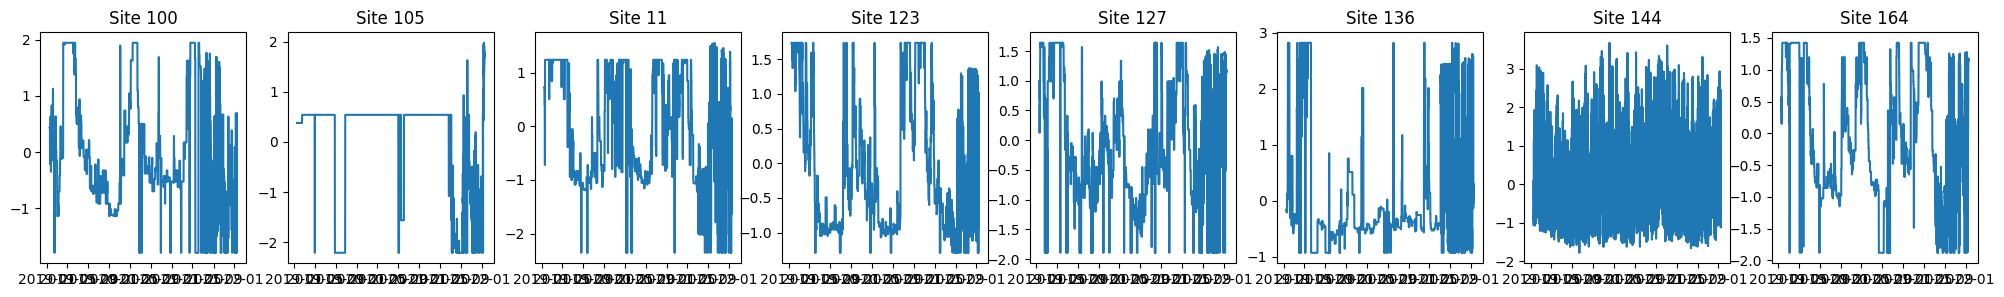

Cluster 5


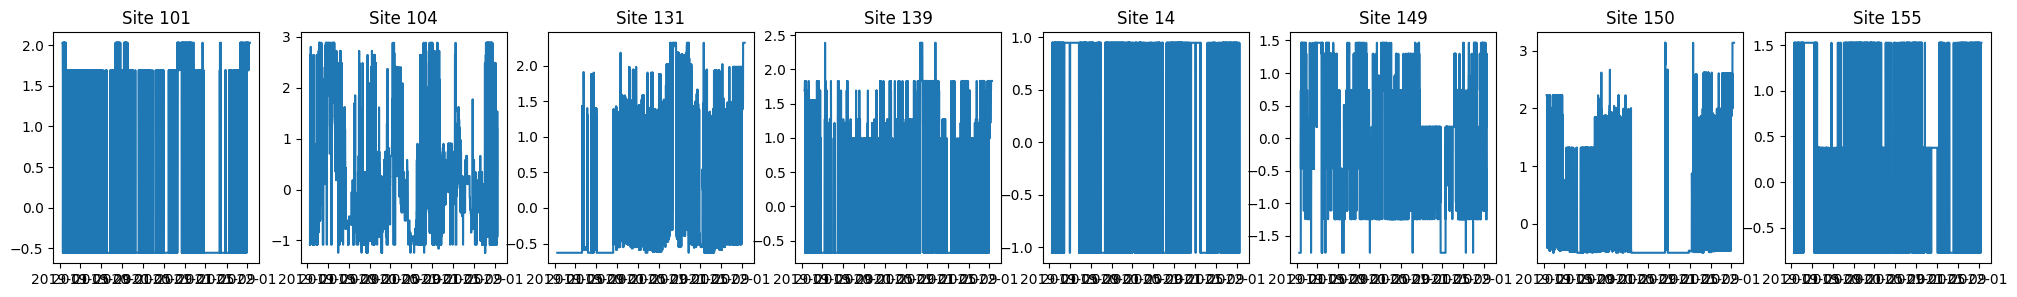

Cluster 1


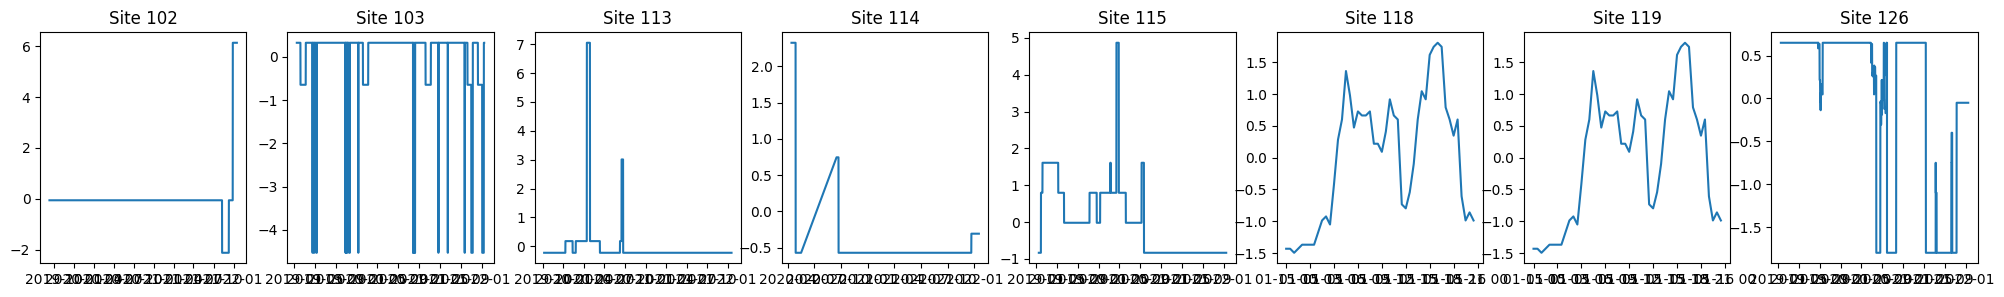

Cluster 3


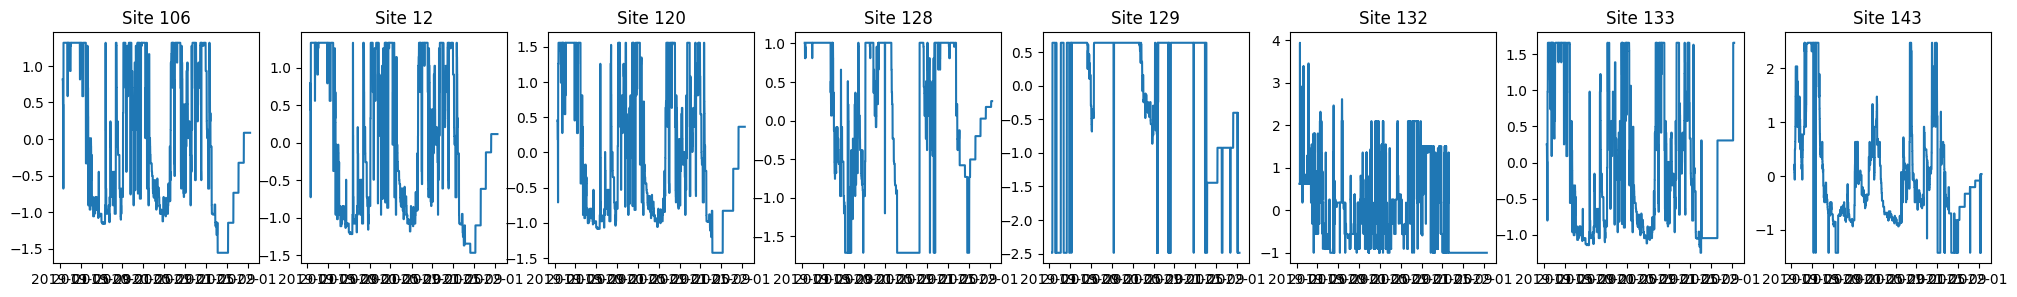

Cluster 0


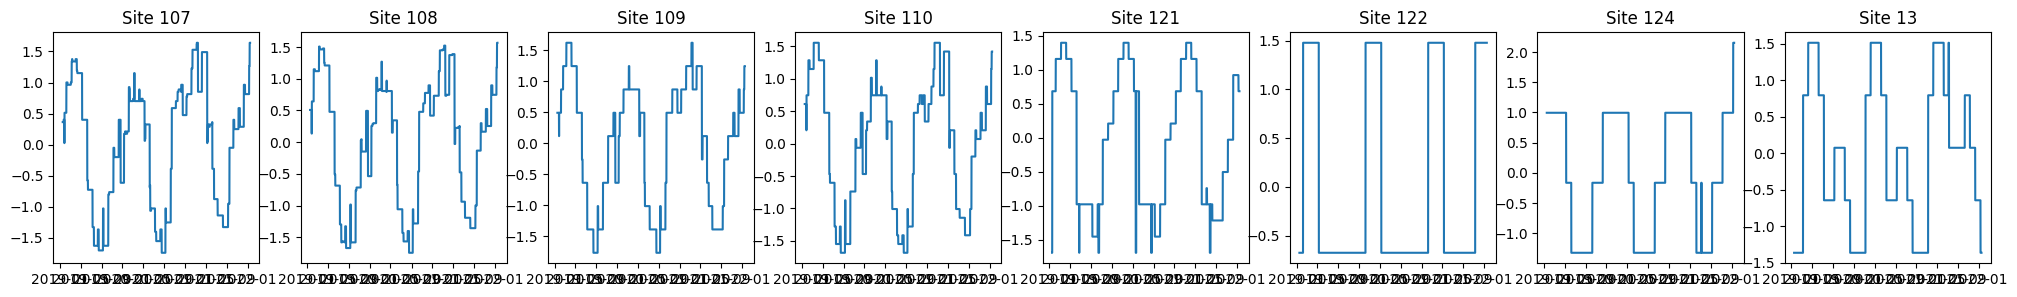

Cluster 2


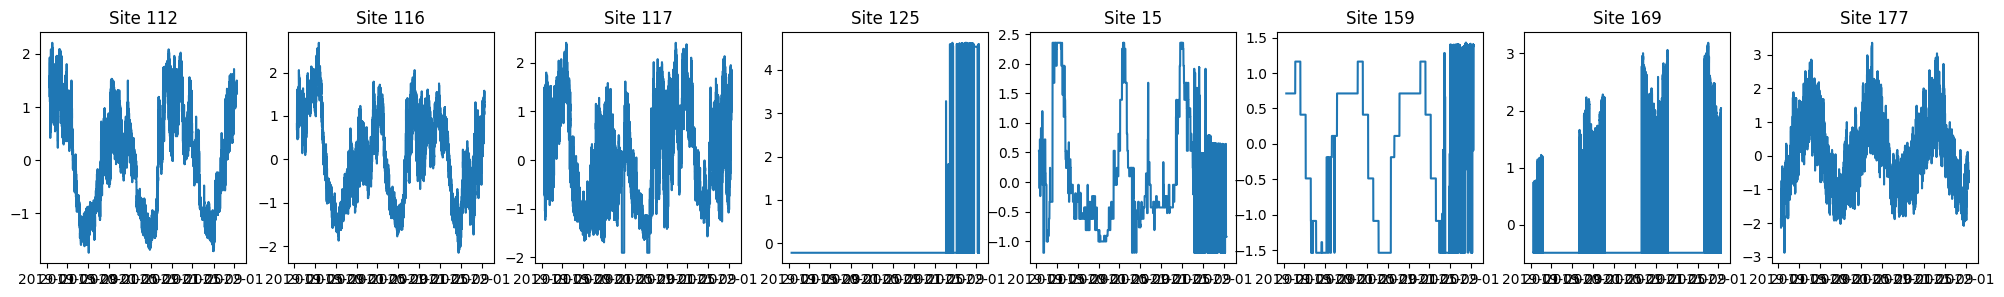

In [22]:
for cluster in features['cluster_n6'].unique():
    print(f'Cluster {cluster}')
    plt.figure(figsize=(25, 3))
    for i, serie_name in enumerate(features[features['cluster_n6'] == cluster].index[:8]):
        df_serie = df[df['SERIE_NAME'] == serie_name]
        plt.subplot(1, 8, i+1)
        plt.plot(df_serie['TIME'], df_serie['VALUE'])
        plt.title(serie_name)
    plt.show()

Ici, on observe que répartitions semblent généralement en première approximation:

- Cluster 0 : Discret, périodique, stationnaire   ---> avec une quantification en valeur plus grossières, un motif qui se repète,une certaine constance à travers le temps de la serie...
- Cluster 1 : Discret, chaotique, non stationnaire
- Cluster 2 : Continue périodique, stationnaire
- Cluster 3 : Continu, chaotique, stationnaire
- Cluster 4 : Continu, chaotique, non stationnaire 
- Cluster 5 : Discret, chaotique, stationnaire

In [23]:
name_cluster = ['Discret, périodique, stationnaire', 'Discret, chaotique, non stationnaire', 'Continu, périodique, stationnaire',
                'Continu, chaotique, stationnaire', 'Continu, chaotique, non stationnaire', 'Discret, chaotique, stationnaire']

In [24]:
representants_3 = features.drop(
    columns=['cluster_n5']).groupby('cluster_n6').median()
representants_3

min       max    median      mean       std      std_sum  \
cluster_n6                                                                  
0          -0.006478  0.006445 -0.000154  0.494820  0.308433    14.471800   
1          -0.006144  0.011044 -0.000777  0.301941  0.277674     7.315881   
2          -0.006093  0.010372 -0.000536  0.370062  0.286196   887.130456   
3          -0.005792  0.007797 -0.000950  0.401538  0.305633    97.260980   
4          -0.006553  0.008333 -0.000968  0.426513  0.284414   312.983670   
5          -0.003257  0.009045 -0.002707  0.264109  0.351182  2099.958027   

            nunique  max_occurence  ampl_fondamental  fréquence_h1  coef_var  \
cluster_n6                                                                     
0               9.0       0.295890        136.735469           9.0  0.000273   
1               5.0       0.592762         76.944293           3.0  0.000155   
2             351.0       0.327683         84.055430           3.0  0.013793   
3              63.0       0.263813        100.179483           2.0  0.001592   
4            2523.0       0.166096         94.053586           7.0  0.003410   
5              97.5       0.501351         60.798545           5.0  0.030090   

            rapport_amplitude  
cluster_n6                     
0                    0.000000  
1                    0.000000  
2                    0.000030  
3                    0.000003  
4                    0.000009  
5                    0.000038

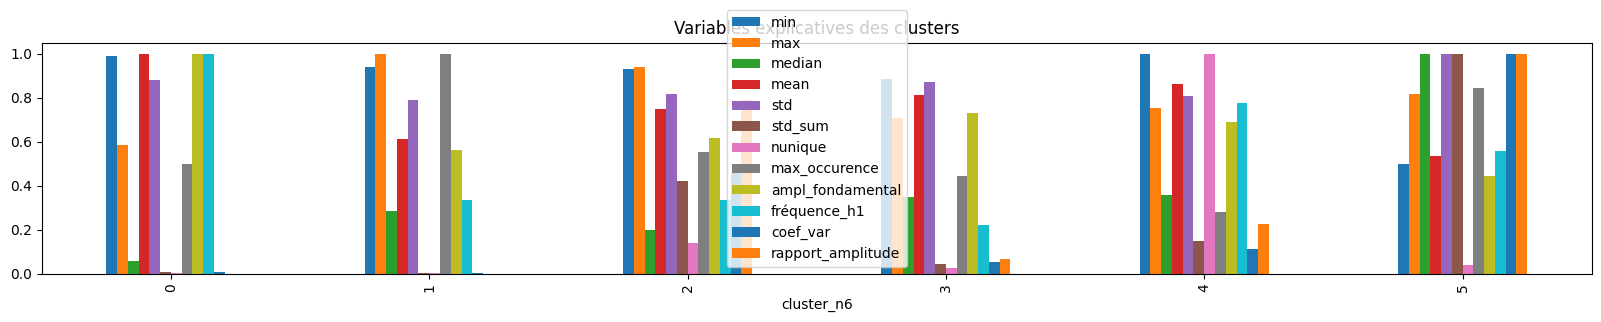

In [25]:
# variables explicatives des clusters, legend en bas
(abs(representants_3)/abs(representants_3).max()).plot.bar(figsize=(20, 3),
                                                           legend=True, title='Variables explicatives des clusters')
plt.show()

In [26]:
features_test['cluster_n6'] = kmedoids_3.predict(
    features_test.drop(columns=['cluster_n5']))

In [27]:
features_test.head(10)

min       max    median      mean       std      std_sum  \
SERIE_NAME                                                                  
Site 0     -0.005943  0.006590 -0.000460  0.474201  0.348050    12.871986   
Site 1     -0.005740  0.009165 -0.001586  0.385093  0.292638    48.059910   
Site 10    -0.001870  0.013019 -0.001870  0.125588  0.292975     4.668547   
Site 2     -0.014291  0.002382  0.002382  0.857139  0.261611    93.026530   
Site 3     -0.002541  0.008484 -0.002541  0.230451  0.395663  1993.627586   
Site 4     -0.014581  0.014373  0.004722  0.503578  0.358851     2.274140   
Site 5     -0.003567  0.009622 -0.002157  0.270484  0.330720    75.353823   
Site 6     -0.004479  0.011509 -0.000482  0.280137  0.272829    11.441766   
Site 7     -0.005549  0.007009  0.000159  0.441873  0.347342  2407.221254   
Site 9     -0.004488  0.009738 -0.000845  0.315467  0.306621    90.823273   

            nunique  max_occurence  ampl_fondamental  fréquence_h1  coef_var  \
SERIE_NAME                                                                     
Site 0           14       0.167123        157.757116            63  0.000243   
Site 1          156       0.037443        142.812533             9  0.000908   
Site 10           8       0.825304         94.173200             3  0.000088   
Site 2           32       0.694901         60.425297             3  0.001757   
Site 3           12       0.742846         70.189482             1  0.031143   
Site 4            8       0.160622         57.667839             3  0.000244   
Site 5          693       0.493151        105.495772             5  0.001041   
Site 6            4       0.452055        123.059493             9  0.000216   
Site 7          114       0.269444         72.848724             9  0.035567   
Site 9          196       0.250038         95.534018             9  0.000949   

            rapport_amplitude  cluster_n5  cluster_n6  
SERIE_NAME                                             
Site 0           0.000000e+00           0           0  
Site 1           0.000000e+00           3           3  
Site 10          0.000000e+00           1           1  
Site 2           0.000000e+00           3           3  
Site 3           2.281469e-05           2           5  
Site 4           0.000000e+00           1           1  
Site 5           2.493291e-06           3           3  
Site 6           0.000000e+00           0           0  
Site 7           1.352105e-05           2           5  
Site 9           9.333046e-07           3           3

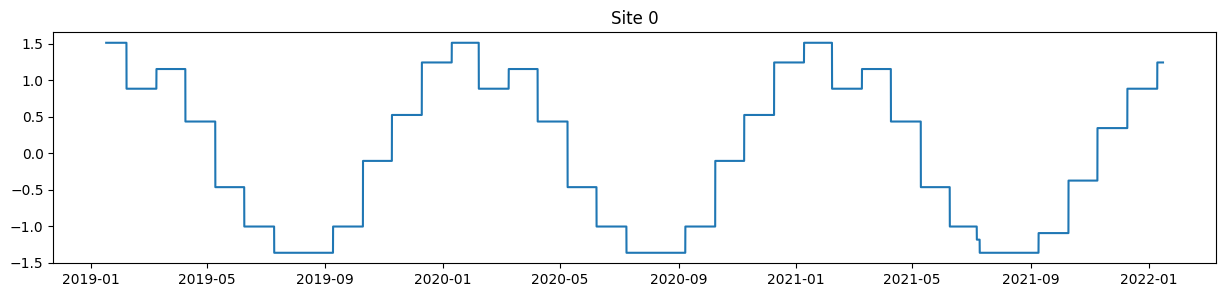

Cluster prédit : 0
Charactéristiques du cluster :  Discret, périodique, stationnaire
Séries temporelles du cluster :
Site 0


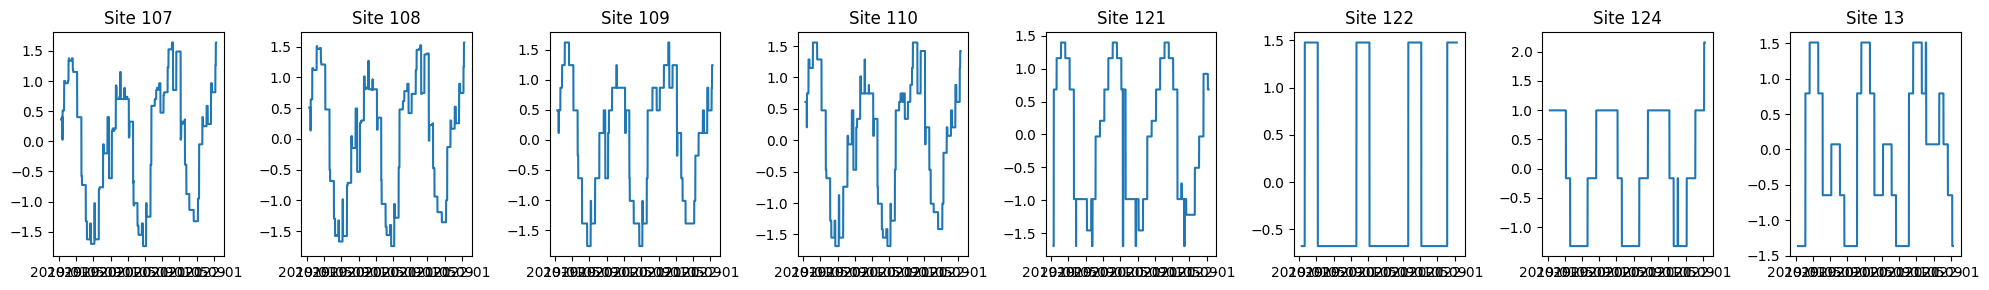

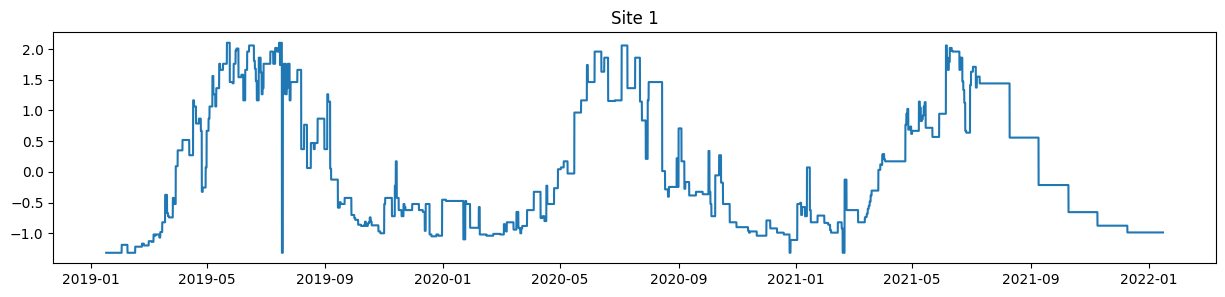

Cluster prédit : 3
Charactéristiques du cluster :  Continu, chaotique, stationnaire
Séries temporelles du cluster :
Site 1


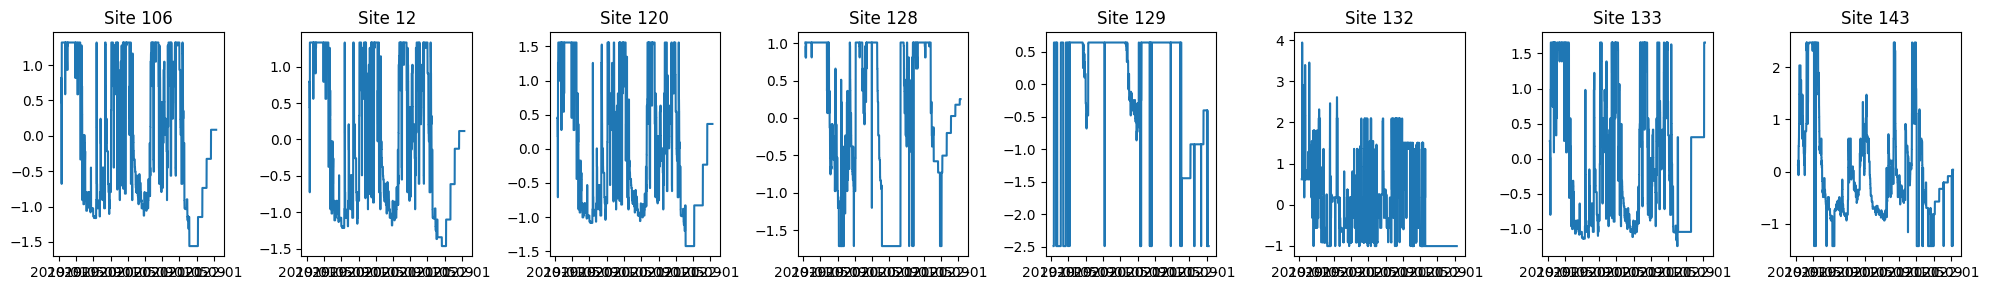

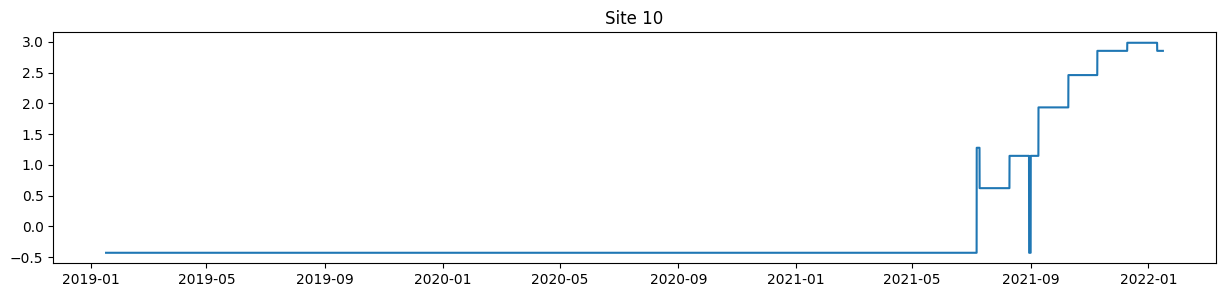

Cluster prédit : 1
Charactéristiques du cluster :  Discret, chaotique, non stationnaire
Séries temporelles du cluster :
Site 10


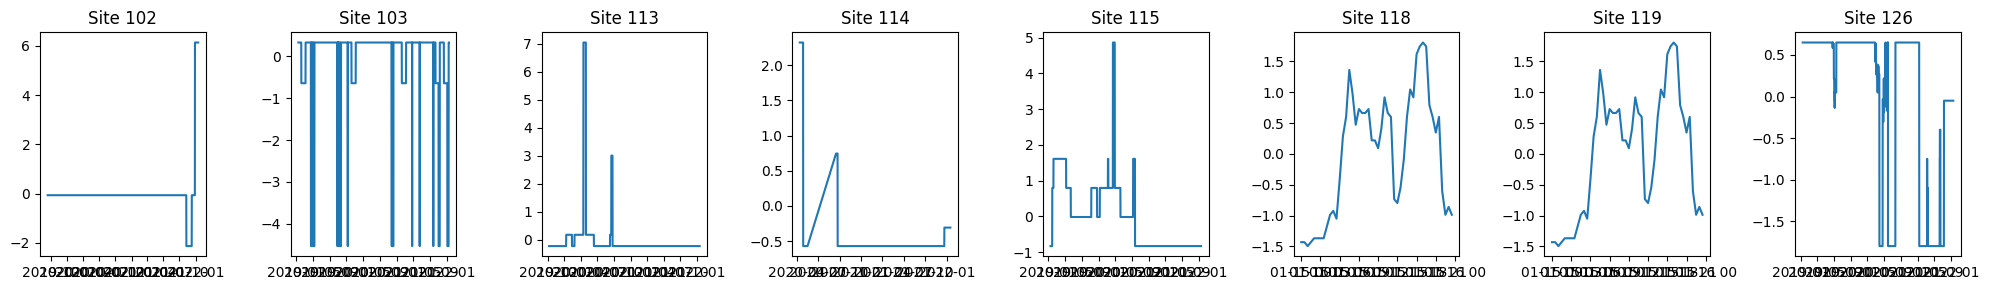

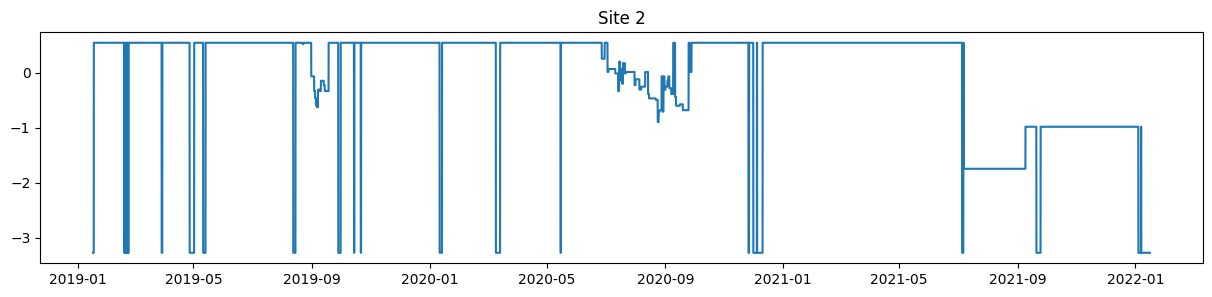

Cluster prédit : 3
Charactéristiques du cluster :  Continu, chaotique, stationnaire
Séries temporelles du cluster :
Site 2


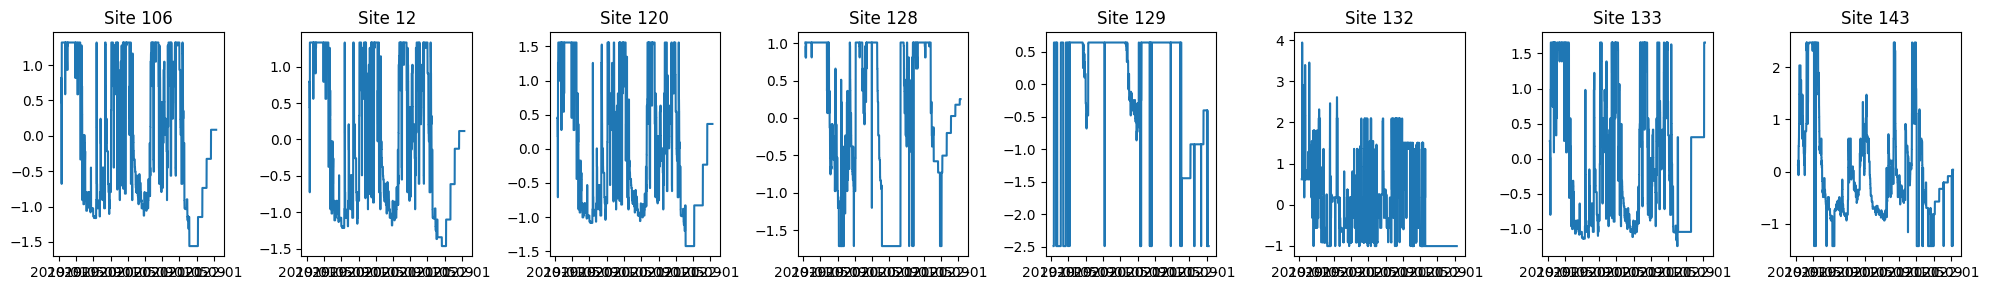

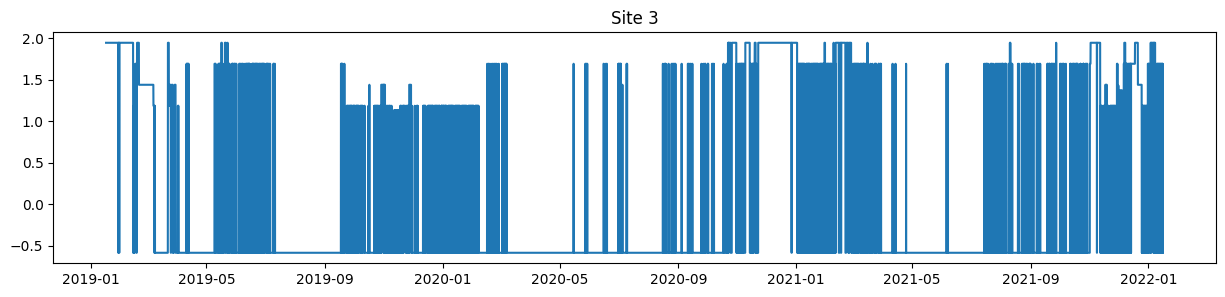

Cluster prédit : 5
Charactéristiques du cluster :  Discret, chaotique, stationnaire
Séries temporelles du cluster :
Site 3


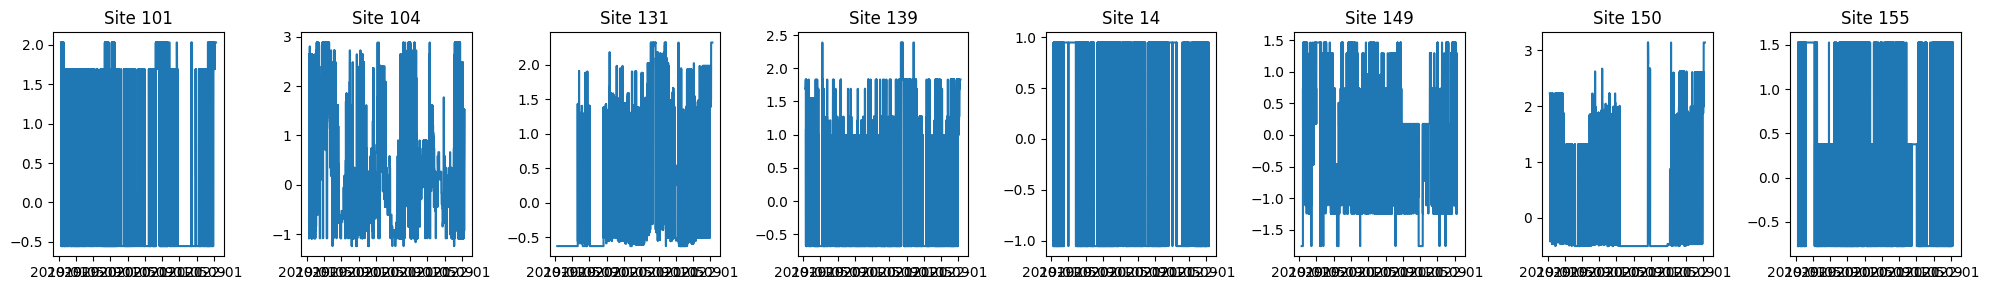

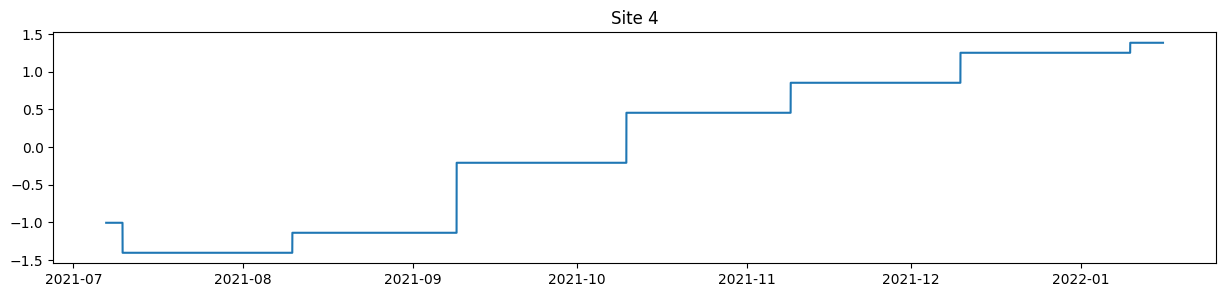

Cluster prédit : 1
Charactéristiques du cluster :  Discret, chaotique, non stationnaire
Séries temporelles du cluster :
Site 4


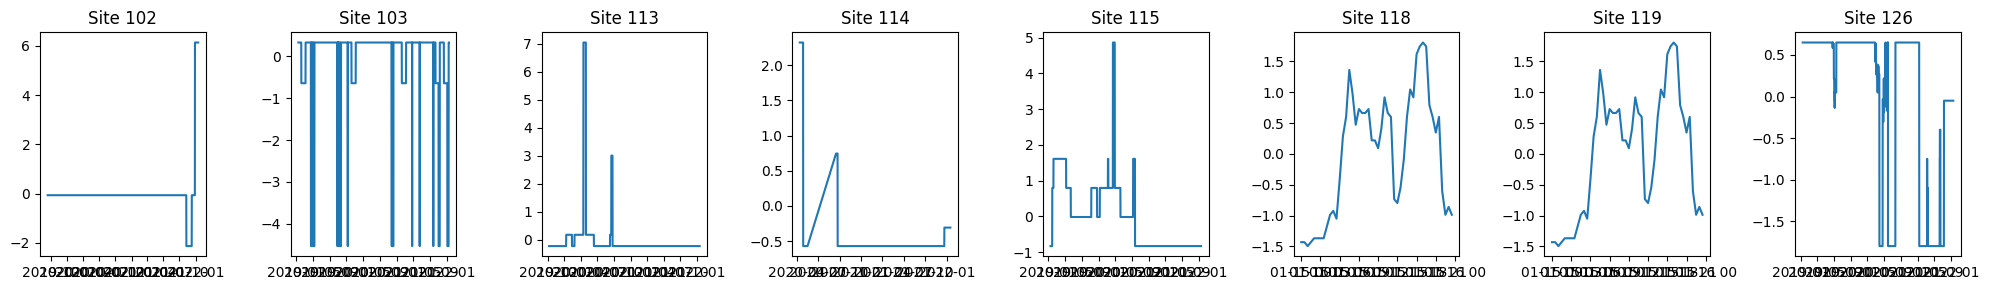

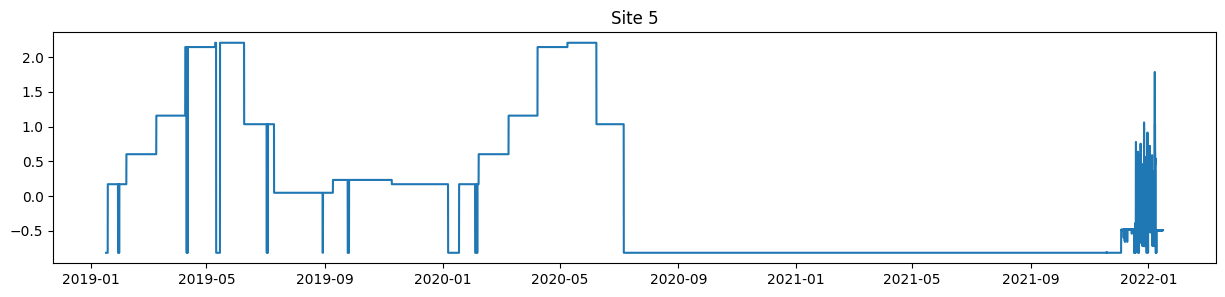

Cluster prédit : 3
Charactéristiques du cluster :  Continu, chaotique, stationnaire
Séries temporelles du cluster :
Site 5


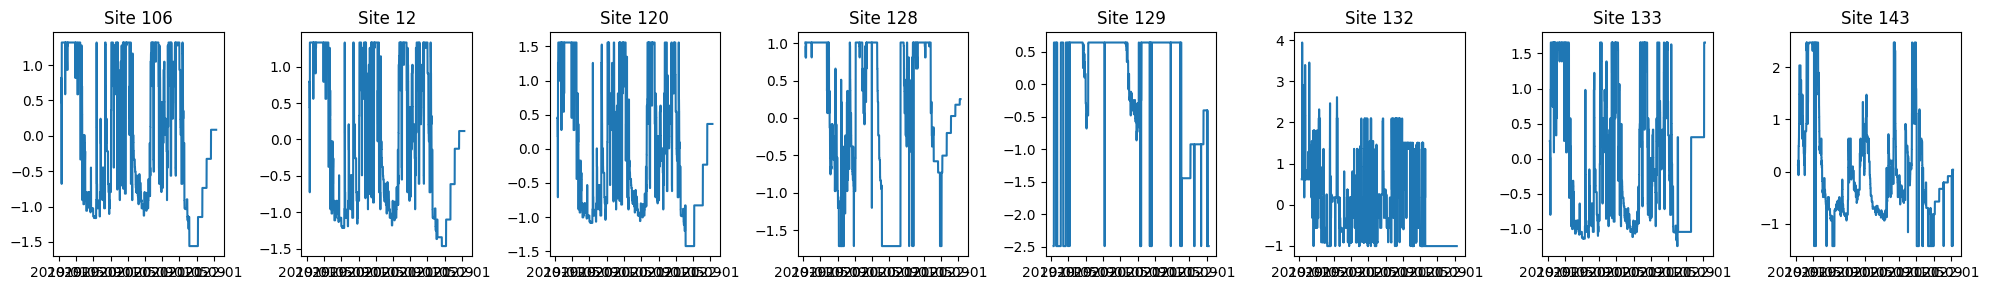

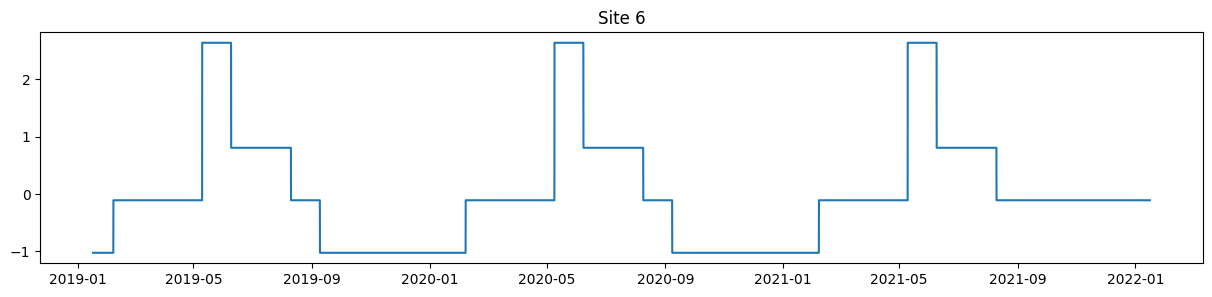

Cluster prédit : 0
Charactéristiques du cluster :  Discret, périodique, stationnaire
Séries temporelles du cluster :
Site 6


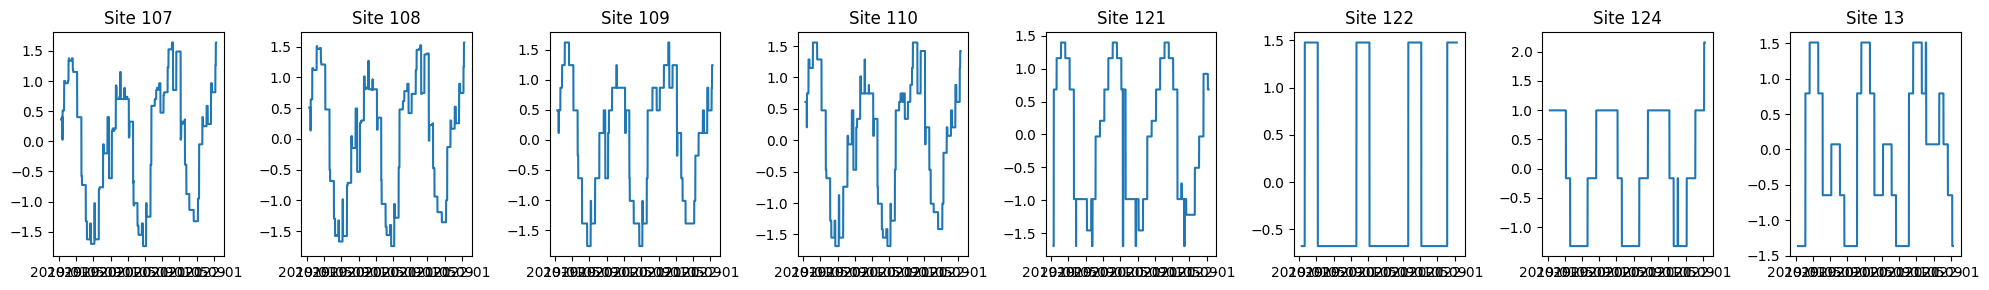

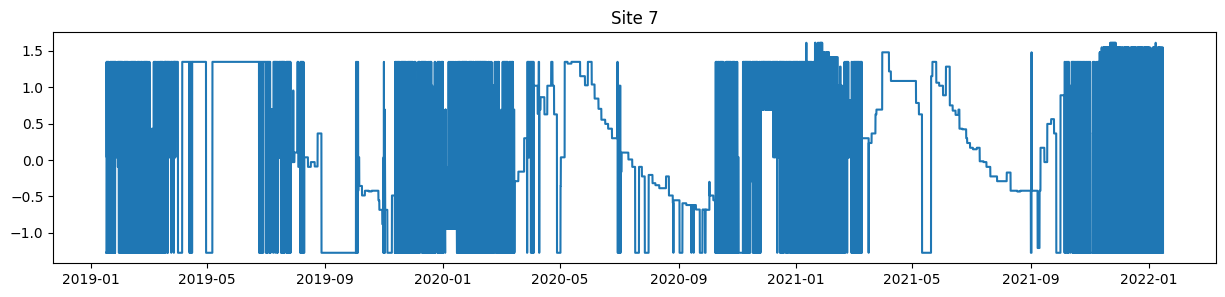

Cluster prédit : 5
Charactéristiques du cluster :  Discret, chaotique, stationnaire
Séries temporelles du cluster :
Site 7


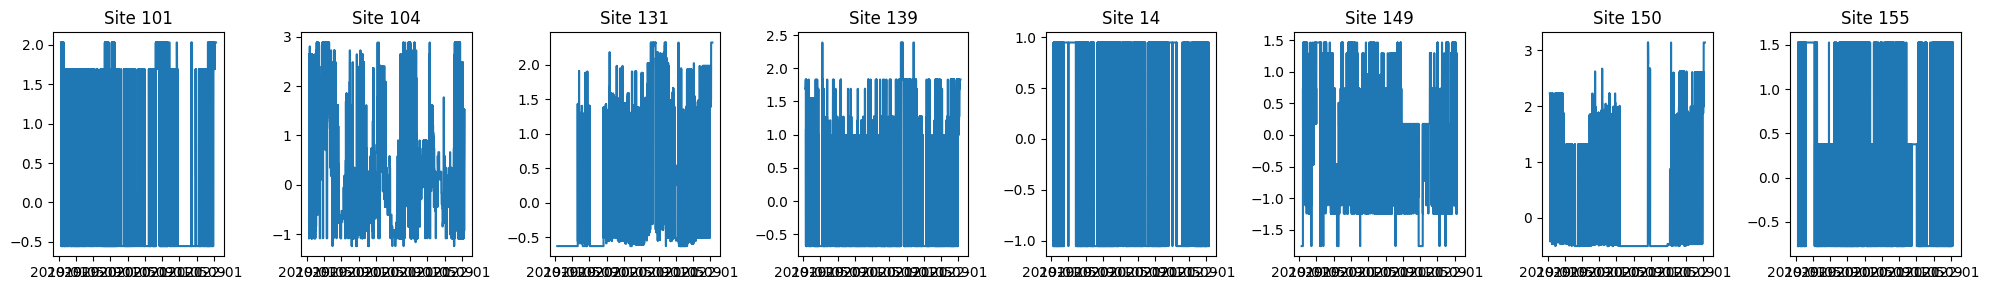

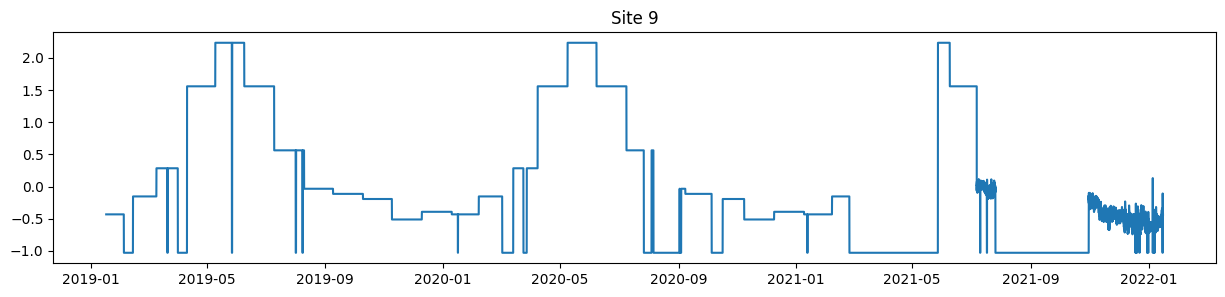

Cluster prédit : 3
Charactéristiques du cluster :  Continu, chaotique, stationnaire
Séries temporelles du cluster :
Site 9


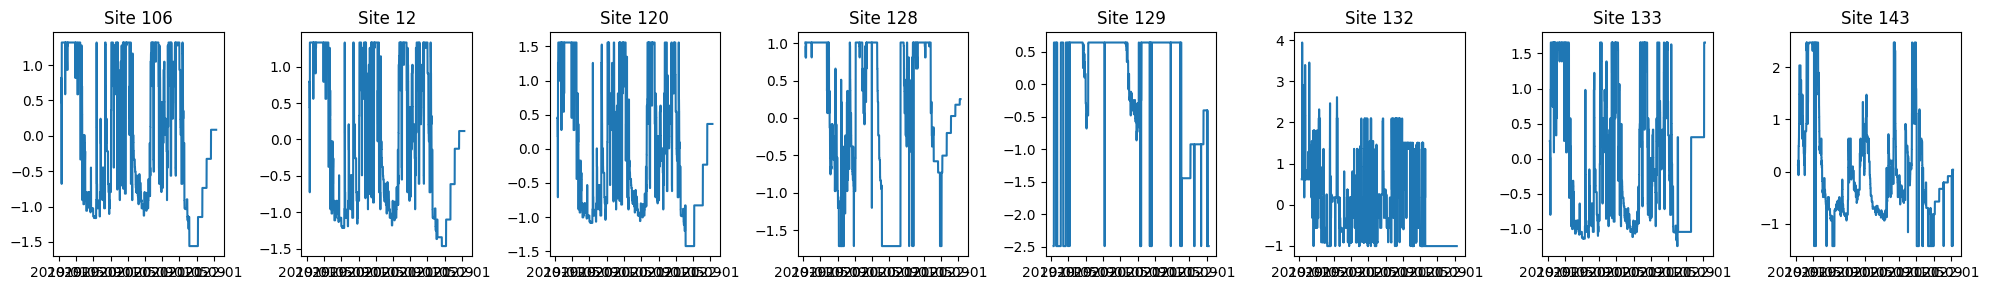

In [28]:
# Plot les séries temporelles de df_test avec les 5 premières séries de leur cluster prédit
for i, serie_name in enumerate(features_test.index[:10]):
    df_serie = df_test[df_test['SERIE_NAME'] == serie_name]
    # Ajustez la taille de la figure selon vos préférences
    plt.figure(figsize=(15, 3))
    plt.plot(df_serie['TIME'], df_serie['VALUE'])
    plt.title(serie_name)
    plt.show()

    print('Cluster prédit :', features_test.loc[serie_name, 'cluster_n6'])
    print('Charactéristiques du cluster : ',
          name_cluster[features_test.loc[serie_name, 'cluster_n6']])
    print('Séries temporelles du cluster :')

    cluster1 = features_test.loc[serie_name, 'cluster_n6']
    print(serie_name)
    # Créez une ligne de 8 sous-graphiques
    fig, axes = plt.subplots(1, 8, figsize=(20, 3))
    for i, serie_name in enumerate(features[features['cluster_n6'] == cluster1].index[:8]):
        df_serie = df[df['SERIE_NAME'] == serie_name]
        ax = axes[i]
        ax.plot(df_serie['TIME'], df_serie['VALUE'])
        ax.set_title(serie_name)

    plt.tight_layout()
    plt.show()

Ca n'a pas vraiment amélioré le traitement des sites 2, 5 et 9, qui sont directement rangés dans la catégorie continu alors qu'ils sont majoritairement discrets. Mais cela permet de différencier toutes les combinaisons. Notamment le cluster 5 n'est plus du tout périodique en reprenant la majorité des profil du cluster 2 d'avant (les profil 3 et 7 y sont alors classés mieux que dans notre 1ère approche). 6 est donc un meilleur nombre de classe pour notre problème.

------

## Ouverture

Je n'ai ici pas forcement eu le temps de faire une méthode de labelisation des series pour utiliser un algorithme du type Random Forest. Je suis restée sur de la clusterisation et une appréciation de cette dernière sur 10 échantillons, ce qui donne une analyse assez restreinte et approximative...


Pour l'implémentation de features, j'ai testé beaucoup de chose en me concentrant sur le spectre de fourier et les intervalles entre pics pour l'aspect périodique; sur la variation de grandeur au cours du temps pour l'aspect stationnaire et chaotique; sur le nombre de valeur et les occurences pour l'aspect discret/continu. J'ai peu fait de combinaison linéaire entre ces derniers, car il m'est apparu peu de combinaisons intéressantes. Je me suis limitée dans cette approche à des features trouvés intuitivement, il en existe de plus pertinents qui donneront alors de meilleurs résultats !